## Title: Food Inspections
### Brief Description: 
This dataset contains information from inspections of restaurants and other
food establishments in Chicago from January 1, 2010 to the present.
### Description: 
This information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program. Inspections are done using a standardized procedure. The results of the inspection are inputted into a database, then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner (LEHP). A subset of data elements are extracted from this database and downloaded into this data portal. These elements are:
* **DBA:**  
Doing business as.’ This is legal name of the establishment.
* **AKA:**  
‘Also known as.’ This is the name the public would know the establishment as.
* **License number:**  
This is a unique number assigned to the establishment for the purposes of licensing by the Department of Business Affairs and Consumer Protection.
* **Type of facility:**  
Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.
* **Risk category of facility:**  
Each establishment is categorized as to its risk of adversely affecting the public’s health, with **1 being the highest** and **3 the lowest**. The frequency of inspection is tied to this risk, **with risk 1 establishments inspected most frequently and risk 3 least frequently.**
* **Street address, city, state and zip code of facility:**  
This is the complete address where the facility is located.
* **Inspection date:**  
This is the date the inspection occurred. A particular establishment is likely to have multiple inspections which are denoted by different inspection dates.
* **Inspection type:**  
An inspection can be one of the following types: **canvass**, the most common type of inspection performed at a frequency relative to the risk of the establishment; **consultation**, when the inspection is done at the request of the owner prior to the opening of the establishment; **complaint**, when the inspection is done in response to a complaint against the establishment; **license**, when the inspection is done as a requirement for the establishment to receive its license to operate; **suspect food poisoning**, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); **task-force inspection**, when an inspection of a bar or tavern is done. **Re-inspections can occur for most types of these inspections and are indicated as such**.
* **Results:**  
An inspection can pass, pass with conditions or fail. Establishments receiving a `pass` were found to have no critical or serious violations **(violation number 1-14 and 15- 29, respectively)**. Establishments receiving a `pass with conditions` were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a `fail` were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such.
* **Violations**:  
An establishment can receive one or more of 45 distinct violations (violation numbers 1-44 and 70). For each violation number listed for a given establishment, the requirement the establishment must meet in order for it to NOT receive a violation is noted, followed by a specific description of the findings that caused the violation to be issued. 

## Disclaimer: 
Attempts have been made to minimize any and all duplicate inspection reports. However, the dataset may still contain such duplicates and the appropriate precautions should be exercised when viewing or analyzing these data. The result of the inspections (pass, pass with conditions or fail) as well as the violations noted are based on the findings identified and reported by the inspector at the time of the inspection, and may not reflect the findings noted at other times.
## Data Owner: 
Chicago Department of Public Health
## Time Period: 
2010 - Present
## Frequency: 
This database will be updated with information from new inspections each Friday. 

Up to date, we have already concluded the research question A and B, which are the main parts of our project. For research question C, we have already collected and preprocessed the data required. For now, our plan is reasonable to produce sound insights for the blog and poster.

Our initial intention was to use the Yelp dataset as the main dataset to be analysed and focus on the success (average rating and etc.) of a restaurant, with food hygiene as a supporting factor. But we dropped this idea as the web-scraped Yelp dataset only contains restaurants in Chicago for now, which might not produce a conclusive and persuasive conclusion or insight that is comprehensive with respect to time span or the food industry. On the other hand, the Chicago Food Inspection dataset is more inclusvie, which contains not only restaurants but also other food establishments. Furthermore, the comments in this dataset produced by the inspection officer gives rich explanation to the hygiene status of a food establishment, which can be utilised with NLP techniques as we have done. Therefore, we have decided to use the Chicago Food Inspection dataset as the main dataset to put analysis on and the Yelp dataset as secondary one to analyse food hygiene from more factors.

In [3]:
import json
import math
import unidecode
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import seaborn as sns
import unidecode
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
import math
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
CHICAGO_PATH = 'food-inspections.csv'
ZIP_CODES_PATH = 'zipcodes.json'

# 0. Data Cleaning

In [5]:
def split_violation(data):
    """An helper function that calculates the number of violations for each inspection
    Args:
        data(dataframe): the inpsection dataset
    Returns:
        data(dataframe): the inpsection dataset with a new column being the number of violations 
        for each inspection
    """
    lss = list()
    for x in data.Violations:
        sets = set()
        if type(x) == str:
            y = x.split("| ")
            for z in y:
                sets.add(z.split(". ")[0])
        lss.append(sets)
        
    data["violation_number"] = pd.Series( (v for v in lss) )
    
    return data

**Deleted columns**

During the data clearing, we removed the following columns: 
1. 'Community Areas','Historical Wards 2003-2015',,'Wards','Zip Codes', 'Census Tracts': These columns only contain NaN values.
2. 'Location': This is duplicate with 'longitude' and 'latitude'.
3. 'City','State': These are the same for every single record (Chicago and IL). 

In [6]:
def read_clean_chicago(path):
    """An helper function that preprocess and cleans the input dataset 
    Args:
        path(str): the file path of the chicago food inspection dataset
    Returns:
        dataset(dataframe): the cleaned chicago food inspection dataset
    """
    # Remove unnecessary columns
    features = ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', \
            'Risk', 'Address', 'Zip', 'Inspection Date', 'Inspection Type',  \
            'Results', 'Violations', 'Latitude', 'Longitude']
    dataset = pd.read_csv(path)[features].drop_duplicates()
    
    def to_lower(x):
        if type(x) == str:
            return x.lower().strip()
        
    def to_int(x):
        if not math.isnan(x):
            return int(x)
    
    # Fill in the License number of a store if it is empty
    dataset['License #'] = dataset['License #'].fillna(-999).astype(int)
    
    dataset['Zip'] = dataset['Zip'].apply(to_int)
    
    # Fill in the DBA name of store if its AKA name is empty
    dataset['AKA Name'][dataset['AKA Name'].isnull()] = dataset['DBA Name'][dataset['AKA Name'].isnull()]
    
    # Change the inspection date from str to DateTime
    dataset['Inspection Date'] = dataset['Inspection Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
    
    features = ['DBA Name', 'AKA Name', 'Address', 'Violations', 'Facility Type', 'Inspection Type', \
                'Inspection Type']
    # Change all str type cells to lower case
    for feature in features:
        dataset[feature] = dataset[feature].apply(to_lower)
    
    dataset.reset_index(drop=True, inplace=True)
    
    dataset = split_violation(dataset)
    
    return dataset.copy()

**Load Data**

In [7]:
# Read in chicago food inspection dataset
chicago = read_clean_chicago(CHICAGO_PATH)

print('The total number of unique establishments in 10 years', chicago['License #'].nunique())
print('Shape of the Chiago dataset', chicago.shape)

chicago.head()


The total number of unique establishments in 10 years 37336
Shape of the Chiago dataset (195524, 15)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,violation_number
0,2345318,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2019-11-08,canvass re-inspection,Pass w/ Conditions,"3. management, food employee and conditional e...",41.927995,-87.785752,"{5, 58, 3}"
1,2345334,la michoacana ice cream shop,la michoacana ice cream shop,2698396,restaurant,Risk 1 (High),3591-3597 n milwaukee ave,60641.0,2019-11-08,license,Pass w/ Conditions,"3. management, food employee and conditional e...",41.946140,-87.735183,"{51, 5, 57, 3}"
2,2345339,the crepe shop,the crepe shop,2699005,restaurant,Risk 1 (High),2934 n broadway,60657.0,2019-11-08,license,Fail,10. adequate handwashing sinks properly suppli...,41.935930,-87.644407,"{48, 55, 51, 53, 39, 10}"
3,2345321,gopuff,gopuff,2684560,grocery store,Risk 3 (Low),1801 w warner ave,60613.0,2019-11-08,license re-inspection,Pass,None,41.956846,-87.674395,{}
4,2345319,gopuff,gopuff,2684558,grocery store,Risk 3 (Low),1801 w warner ave,60613.0,2019-11-08,license re-inspection,Pass,39. contamination prevented during food prepar...,41.956846,-87.674395,"{51, 39}"


**Violation Score**

Here we propose a scheme to calculate a Violation Score that calculates the violation penalty score of a food establishment over a specific span of time.

For every inspection:

1. If an establishment never violates any inspection regulation, it receives 0 violation penalty score.
2. If an establishment violates one inspection regulation:
    * If its inspection result is 'Fail', then +2 for every violation;
    * If its inspection result is 'Pass with condition', then +1 for every violation;
    * If its inspection result is pass, then +0.5 for every violation;
3. If a violation is repeated from the previous inspection, then +1 for every repeated violation. 
4. Then the single violation penalty score for an establishment is calculated by using an exponential decay     averageweighting giving a half-life of the exponential decay (50% weight) to be at 1 year from the latest inspection. 

The total violation penalty score is then calculated by adding violation penalty score from very single inspection

In [6]:
def compute_violation_score(License_violation):
    """An helper function that computes a health score for each establishment 
    Args:
        License_violation(DataFrameGroupBy): A grouped dataframe that consists of violations of a paticular  
        food establishment
    Returns:
        score(int): the aggregated health score for a food establishment over all provided inspections
    """
    License = License_violation.sort_values(by = "Inspection Date")
    total_score = 0
    critical_violation = []
    number_of_inspection = len(License)
    most_recent_inspection_date = License['Inspection Date'].iloc[-1]
  
    for i in range(number_of_inspection):
        score = 0
        violation_set = License.violation_number.iloc[i]
        total_number_of_violation = len(violation_set)
        number_of_critical_violation = [int(x) in critical_violation for x in violation_set].count(True)
        
        if i is not 0:
            number_of_repeated_violation = len(violation_set.intersection(License.violation_number.iloc[i-1]))
            score += total_number_of_violation + number_of_critical_violation + number_of_repeated_violation
          
        else:
            score += total_number_of_violation + number_of_critical_violation
                     
        if(License.Results.iloc[i] == 'Fail'):
            score +=  total_number_of_violation 
            
        if(License.Results.iloc[i] == 'Pass'):
            score -=  0.5*total_number_of_violation            
        
        deltaD = (most_recent_inspection_date- License['Inspection Date'].iloc[i]).days
        
        total_score += math.exp(-0.0018990333713*deltaD) * score

    return total_score

**Health Score**

Here we propose a scheme to calculate a Health Score that calculates the cleanlinessof a food establishment over a specific span of time.

According to the violation score we calualted, a food establishment who has the highest violation score will be ranked 1. Then health score is calculated by normolized the violation score rankng. The food establishment who ranked last will hashealth score 100 and the food establishment who ranked 1 will have health score 0.

In [7]:
def compute_health_socre(chicago_period, data):
    """An helper function that computes a health score for each establishment 
    Args:
        chicago_period(DataFrameGroupBy): dataframe that consists specific time period
    Returns:
        data(int): dataframe with health score for a food establishment over all provided inspections
    """

    chicago_health = chicago_period.groupby("License #")\
                        .apply(lambda x: compute_violation_score(x)).to_frame().rename(columns= {0:"violation_score"})\
                        .reset_index()
    chicago_health = chicago_period.merge(chicago_health, on = 'License #', how = 'inner')
    chicago_health = chicago_health[chicago_health['License #'] > 0]

    chicago_health = chicago_health[['License #','violation_score','Zip','Risk','Facility Type']].drop_duplicates()
    chicago_health.dropna(inplace = True)
    
    chicago_health_temp = chicago_health.copy()

    chicago_health["violation_score_Rank"] = chicago_health["violation_score"].rank(ascending = False) 

    range_len = np.max(chicago_health['violation_score_Rank']) - np.min(chicago_health['violation_score_Rank'])
    chicago_health['health_score'] = (chicago_health['violation_score_Rank'] - np.min(chicago_health['violation_score_Rank'])) / range_len
    chicago_health['health_score'] = chicago_health['health_score'] *100
    
    return chicago_health, chicago_health_temp

In [8]:
def compute_health_socre_all(data_old, data_new):
    """An helper function that computes a health score for each establishment that span over 10 years 
    Args:
        chicago_period(DataFrameGroupBy): dataframe that span over 10 years
    Returns:
        data(int): dataframe with health score for a food establishment over all provided inspections
    """

    chicago_health = data_new[['License #','violation_score']]\
                         .merge(data_old[['License #','violation_score']], on = 'License #', how = 'outer').fillna(0)
    chicago_health['violation_score'] = chicago_health['violation_score_x'] + chicago_health['violation_score_y'] 

    chicago_health["violation_score_Rank"] = chicago_health["violation_score"].rank(ascending = False) 

    range_len = np.max(chicago_health['violation_score_Rank']) - np.min(chicago_health['violation_score_Rank'])
    chicago_health['health_score'] = (chicago_health['violation_score_Rank'] - np.min(chicago_health['violation_score_Rank'])) / range_len
    chicago_health['health_score'] = chicago_health['health_score'] *100
    chicago_health = chicago_health.merge(chicago, on = 'License #')
    
    return chicago_health[['License #','violation_score','Zip','Risk','violation_score_Rank','health_score','Facility Type']]

**Split Data**

According to Chicago Department of Public Health, the scheme used for inspection has a major change on July 1st, 2018. Therefore, we decide to partion this food inspection dataset according to this date and do seperate analysis for:
1. Before the change of scheme. 
2. After the chane of scheme. 
3. Accumulative effect of 10 years. 

In [9]:
new_scheme = datetime(2018, 7, 1)
chicago_old = chicago[chicago['Inspection Date'] < new_scheme]
chicago_new = chicago[chicago['Inspection Date'] > new_scheme]

**Compute chicago health dataframe for period before 2018, after 2018 and between 2008 to 2018**

chicago health dataframe for period before 2018

In [10]:
chicago_health_before, chicago_before = compute_health_socre(chicago_old,chicago)
chicago_health_before.sort_values(by = 'violation_score').head()

,License #,violation_score,Zip,Risk,Facility Type,violation_score_Rank,health_score
172728,1992040,0.0,60613.0,Risk 1 (High),restaurant,28181.5,100.0
138344,2042722,0.0,60614.0,Risk 2 (Medium),bakery,28181.5,100.0
138389,2009240,0.0,60629.0,Risk 3 (Low),grocery store,28181.5,100.0
138484,2277575,0.0,60618.0,Risk 3 (Low),wholesale,28181.5,100.0
138546,2350157,0.0,60602.0,Risk 1 (High),restaurant,28181.5,100.0


chicago health dataframe for period after 2018

In [11]:
chicago_health_after, chicago_after = compute_health_socre(chicago_new, chicago)
chicago_health_after.sort_values(by = 'violation_score').head()

,License #,violation_score,Zip,Risk,Facility Type,violation_score_Rank,health_score
19151,18272,0.0,60623.0,Risk 1 (High),restaurant,11466.5,100.0
15224,2641576,0.0,60654.0,Risk 1 (High),restaurant,11466.5,100.0
21211,2215549,0.0,60642.0,Risk 1 (High),children's services facility,11466.5,100.0
19515,1447481,0.0,60628.0,Risk 2 (Medium),grocery store,11466.5,100.0
3701,2683669,0.0,60605.0,Risk 3 (Low),restaurant,11466.5,100.0


chicago health dataframe for period within 10 years

In [12]:
chicago_health = compute_health_socre_all(chicago_before,chicago_after)
chicago_health.sort_values(by = 'violation_score').head()

,License #,violation_score,Zip,Risk,violation_score_Rank,health_score,Facility Type
195846,1992040,0.0,60613.0,Risk 1 (High),30573.5,100.0,restaurant
178687,30615,0.0,60634.0,Risk 3 (Low),30573.5,100.0,repackaging plant
122767,2560879,0.0,60657.0,Risk 3 (Low),30573.5,100.0,grocery store
122768,2560879,0.0,60657.0,Risk 3 (Low),30573.5,100.0,grocery store
122825,2522429,0.0,60622.0,Risk 1 (High),30573.5,100.0,restaurant


## Helper Fuction: Average Rate
There are several possible approaches to compute the average result rate. But here we take the approach as following with zip code as an example feature:
1. Compute the individual pass, pass with condition and fail rate of a food establishment
2. Count the total number of food establishments in this zip code
3. Compute the average rate of food establishments in this zip code

As we know food establishments have different risk level and hence are inspected by different frequencies. Additionally, a fail result might result to another inspection. Therefore, this approach make the computed rate fair with respect to each food establishment and do not assert too much weight on an establishment that is oftenly inspected. 

In [13]:
def compute_avg_rate(data, feature):
    """Compute the average pass, pass with condition and fail rate grouped by this specific feature. 
    Args:
        data (Pandas dataframe): the dataset to analyse on 
        feature (str): on which feature we wish to group by
    Returns:
        final_df: a dataframe with the index being categories of the feature column and the columns
                  being pass rate, fail rate and pass with condition rate
    """
    # Here we only consider the pass, pass with condition and fail rate
    data = data[data['Results'].isin(['Pass', 'Fail', 'Pass w/ Conditions'])]
    
    # The total number of inspections of an individual establishment
    grouped_inspectionSumPerShop = data.groupby([feature, 'License #'])\
                                       .count()[['Inspection ID']]\
                                       .rename(columns={"Inspection ID": "#inspection"})
    
    # The number of Pass, Fail and Pass With Conditions respectively of an individual establishment
    grouped_inspectionSumPerRatePerShop = data.groupby([feature, 'License #', 'Results'])\
                                              .count()[['Inspection ID']]\
                                              .rename(columns={"Inspection ID": "#time"})
    
    grouped_inspectionSumPerRatePerShop.reset_index(level = 2, inplace = True) 
    grouped_results_total = grouped_inspectionSumPerRatePerShop.merge(grouped_inspectionSumPerShop, on=[feature,'License #'], how = 'right')
    
    # Compute the Pass, Fail and Pass With Conditions rate by division of each individual establishment
    grouped_results_total["individual_rate"] = grouped_results_total["#time"]/grouped_results_total["#inspection"]
    grouped_results_total = grouped_results_total.reset_index().set_index([feature])
    
    # The total number of establishments in this category of feature
    final_df = grouped_results_total.groupby([feature,'Results']).sum().reset_index().set_index([feature])\
          .merge(data[['License #', feature]].drop_duplicates().groupby(feature).count(), on = feature)\
          .rename(columns={"License #_y": "totla_number_of_License"})
    
    # The average Pass, Fail and Pass With Conditions rate in this category of feature
    final_df['rate'] = final_df['individual_rate']/final_df['totla_number_of_License']
    final_df = final_df.pivot(columns='Results', values='rate')
    return final_df

In [14]:
def compute_plot(data,xlabel,ylabel,title, flag):
    """Plot the Pass, Fail and Pass With Conditions rate with respect to the index of data
    Args:
        data (Pandas dataframe): the dataset returned from function 'compute_avg_rate'
        xlabel (str): the name of x axis
        ylabel (str): the name of y axis
        title (str): title of the plot
        flag (boolean): plot the tendency line of 'Fail' or not
    """
    fig, ax = plt.subplots(figsize=(10,7))
    w = 0.2
    x = data.index
    ax.bar(x-w, data['Pass'], width=w, color='b',label='Pass')
    ax.plot(x-w, data['Pass'], '-o', color='orange')
    ax.bar(x, -data['Fail'], width=w, color='g',label='Fail')
    if flag:
        ax.plot(x, -data['Fail'], '-o', color='orange')
    ax.bar(x+w, -data['Pass w/ Conditions'], width=w, color='r',label='Pass w/ Conditions')
    ax.legend(bbox_to_anchor=(1.3, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

# Part A. Inspection-Related Questions:
1. Time: Is there a seasonal pattern for inspection results of food establishments in Chicago? How about a a yearly pattern? What tendency does the inspection result of each region exhibit during the recorded nine years?
2. Region: Is there a relationship between the cleaniness of food establishments and the quality of the zip-based region? What is the distribution of cleaniness w.r.t. zips?
3. Risk Level: How does the risk level of a food establishment influence its cleaniness?
4. Facility Type: Which facility type is the cleaniest? What is the ranking of facility types according to cleaniness?

---
# 0. How we define cleaniness
# Cleaniness Metrics

We wish to analyse the average cleaniess of restaurants in Chicago from different perspectives. But how can we define what is a "Clean" restaurant? Here we propose two approaches:

**I. Pass-Rate Metric**\
With result rate (pass, fail, pass with condtion) as the metric to define "Clean". Each time a food establishment is inspected, it will receive a result. So we define a clean food establishment is a food establishment that receives a pass for most of its inspections and vice versa. With the average rate function propsed above in section 0, we can compute such a rate.

**II. Health-Score Metric**\
With health score as the metric to define "Clean". This is a more accumulative view to judge a food establishment. With the health score scheme proposed as in section 0, we can use such a metric to weight a food establishment.

With these two cleaniness standards defined, we are now equipped to start our analysis of the food establishment's cleaniness status of Chicago from different perspectives: time, region, risk level and facility type. 

-----

# 1. Analysis by Time

From the perspective of time, we can only use the Pass-Rate Metric, as the Health-Score Metric is an accumulative metric that uses time to accumulate the historical inspection results. 

## 1.1 Is there a seasonal pattern for inspection results?

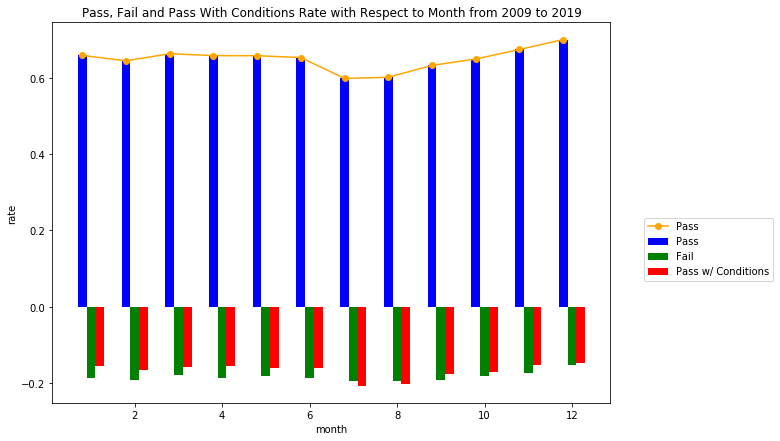

In [15]:
chicago['month'] = chicago['Inspection Date'].dt.month
rate_per_month = compute_avg_rate(chicago, 'month')
compute_plot(rate_per_month,'month','rate','Pass, Fail and Pass With Conditions Rate with Respect to Month from 2009 to 2019', False)

**Observation**: The distribution of the rates over months is in general smooth. However, in the **summer** (July and August), the pass rate is apprarently lower than the other months and the pass with condition rate is slightly higher than the other months.

## 1.2. Is there a yearly pattern?

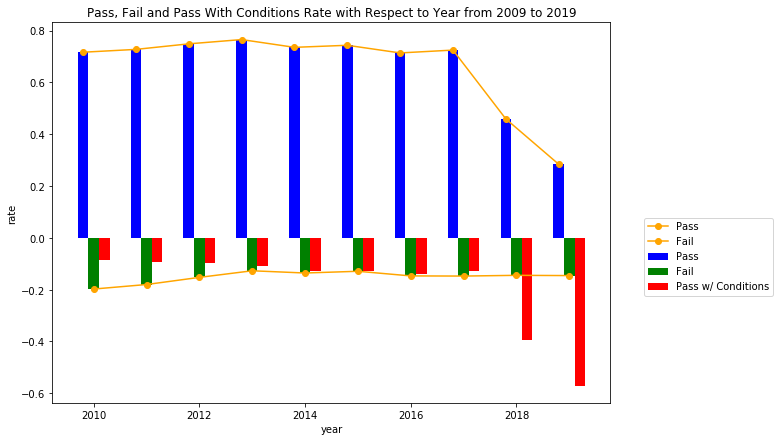

In [16]:
chicago['year'] = chicago['Inspection Date'].dt.year
rate_per_year = compute_avg_rate(chicago, 'year')
compute_plot(rate_per_year,'year','rate','Pass, Fail and Pass With Conditions Rate with Respect to Year from 2009 to 2019', True)

**Analysis**: According to Chicago Department of Public Health, the scheme used for inspection has a major change on July 1st, 2018. This is also reflected in the plot, from 2018 it sees a significant change of results. The **pass rate** has dropped significantly, which is compensated by a dramatically increasing **pass with condition** rate. This can be interpreted as a much **stricter scheme** which discovers more problems that can be solved during the inspection.The **fail rate** slightly decreases with respect to year, indicating that the overall cleaniess situation of Chicago's food industry is improving.

# 2. Analysis by ZIP Code -- Is there a regional pattern for inspection results?

## 2.1. Pass-Rate Metric
### 2.1.0. Helper Fuctions

In [15]:
def read_external_zip(file_path):
    """A helper function that reads in the zip codes used for plotting the map of Chicago
    Args:
        file_path (str): file path of the json file
    Returns:
        external_zip(list): list of zip codes used for plotting the map of Chicago
        geo_json_data(json): coordinates of each zip region in Chicago
    """
    state_geo_path = file_path
    geo_json_data = json.load(open(state_geo_path))

    external_zip = []
    for i in range(49):
        v = int(pd.read_json(state_geo_path)['features'].loc[i]['properties']['ZIP'])
        external_zip.append(v)
    
    return external_zip, geo_json_data

In [16]:
def compute_dataframe_for_map(chicago, data, external_zip):
    """A helper function that rearranges the data for plotting the map
    Args:
        chicago(dataframe): chicago food inspection dataset
        data(dataframe): dataframe requiring reordering of index
        external_zip(list): list of zip codes used for plotting the map
    Returns:
        map_data(dataframe): dataframe ready to be plotted in the map
    """
    my_dataframe = []
    myzip = chicago.Zip.unique().tolist()

    for zip in external_zip:
        if zip not in myzip:
            length = len(data.columns)
            row = [zip] + [0 for i in range(length)]
        else:
            row = [zip] + data.loc[zip].values.tolist()
        my_dataframe.append(row)

    map_data = pd.DataFrame(my_dataframe, columns = ['Zip'] + data.columns.tolist())
    map_data['Zip'] = map_data['Zip'].astype(str)
    return map_data

In [17]:
def plot_zip_map(path, chicago, feature):
    """A helper function that plots the map of chicago and helath score of each zip-based region
    Args:
        path(str): path of external json file
        chicago(dataframe): chicago food inspection dataset
        feature(str): which feature should the map plot show 
    Returns:
        chicago_map(map object): map plot
    """
    external_zip, chicago_geo_json_data = read_external_zip(path)
    data = chicago[chicago['License #'] > 0]
    data = data[data['Zip'].isin(external_zip)]

    zip_rate = compute_avg_rate(data,'Zip')
    
    chicago_coord = [41.881832, -87.623177]
    chicago_map = folium.Map(location=chicago_coord,tiles='cartodbpositron')
    zip_rate_data = compute_dataframe_for_map(chicago, zip_rate, external_zip)

    chicago_map.choropleth(geo_data=chicago_geo_json_data, data=zip_rate_data,
                 columns=['Zip', feature],
                 key_on='feature.properties.ZIP',
                 fill_color='BuPu', 
                 legend_name= feature + 'Rate')
    
    return chicago_map

### 2.1.1. Result Visulisation and Analysis

**a. Chicago map by FAIL rate for each ZIP (in 10 years)**\
The darker a region, the more likely its restaurants are going to fail in an inspection.

In [22]:
plot_zip_map(ZIP_CODES_PATH, chicago, 'Fail')

<img src='data/2.1.1.a..png'>

**Analysis** 
As shown in the plot, the general cleaniness condtion in the north is arguably better than the south. 

Additionally, according to City of Chicago Government [1], below we give the **Life Expectacy at Birth** in each region of Chicago. 

<img src="data/chicago life expectancy.png">

We observe that the life expectancy and the fail rate of food inspection do have numerous similarities wth respect to the distribution pattern: food establishments in the north usually outperforms those in the south, and accordingly people in the north have a longer life expectancy than those in the south. 

For instance, regions A(Austin), B(West Garfiled Park) and C(North Lawndale) have the lowest life expectancy (around 63.1-73.7) in Chicago, and food establishments in those regions have a relatively higher fail rate during inspections (26% - 31%), indicating an inferior food industry. 

Additionally, according to the life expectancy plot, communities with **economic hardship** (shaded regions) also have food establishments of higher fail rate. Namely the economic hardship also has a high correlation with fail rate during a food inspection.

[1] https://www.chicago.gov/content/dam/city/depts/cdph/CDPH/HC2.0Plan_3252016.pdf

**b1. Chicago map by FAIL rate for each ZIP (old inspection scheme)**\
The darker a region, the more likely its restaurants are going to fail in an inspection.
The data used from are before 2018.JUL.01

In [23]:
plot_zip_map(ZIP_CODES_PATH, chicago_old, 'Fail')

<img src='data/2.1.1.b1..png'>

**b2. Chicago map by Pass w/ Conditions rate for each ZIP (old inspection scheme)**\

In [24]:
plot_zip_map(ZIP_CODES_PATH, chicago_old, 'Pass w/ Conditions')

<img src='data/2.1.1.b2..png'>

**c1. Chicago map by FAIL rate for each ZIP (new inspection scheme)**\
The darker a region, the more likely its restaurants are going to fail in an inspection.
The data used from are after 2018.JUL.01

In [25]:
plot_zip_map(ZIP_CODES_PATH, chicago_new, 'Fail')

<img src='data/2.1.1.c1..png'>

**c2. Chicago map by Pass w/ Conditions rate for each ZIP (new inspection scheme)**

In [26]:
plot_zip_map(ZIP_CODES_PATH, chicago_new, 'Pass w/ Conditions')

<img src='data/2.1.1.c2..png'>

**Analysis** By comparing b1 and c1, we do observe that after 2018.JUL.01, the overall cleaniness situation of food establishments in Chicago is turning better, as the fail rate is dropping in general, which is again confirmed by comparing b2 and c2, where the pass with conditions rate increased dramatically. 

## 2.2. Health-Score Metric

### 2.2.0. Helper Functions

In [18]:
def compute_plot_zip_health_map(data, path):
    """A helper function that computes the health score for each zip-based region
    Args:
        data(dataframe): chicago food inspection dataset
        path(str): file path of the json file
    Returns:
        zip_health(dataframe): dataframe for health score w.r.t. zip code
        chicago_map(map object): map plot
    """
    external_zip, chicago_geo_json_data = read_external_zip(path)
    
    # Compute
    zip_health = data[data['Zip'].isin(external_zip)]\
            [['License #', 'health_score', 'Zip']].drop_duplicates()\
            .groupby('Zip').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score')
    
    #!!!!!!!
    range_len = np.max(zip_health['health_score']) - np.min(zip_health['health_score'])
    zip_health['health_score'] = 100*(zip_health['health_score'] - np.min(zip_health['health_score'])) / range_len
    
    # Plot
    chicago_coord = [41.881832, -87.623177]
    chicago_map = folium.Map(location=chicago_coord,tiles='cartodbpositron')
    
    health_score_data = compute_dataframe_for_map(data, zip_health, external_zip)

    chicago_map.choropleth(geo_data=chicago_geo_json_data, data=health_score_data,
                 columns=['Zip', 'health_score'],
                 key_on='feature.properties.ZIP',
                 fill_color='BuPu', 
                 legend_name='health_score Rate (%)')
    
    return chicago_map, health_score_data

### 2.2.1. Result Visulisation

**a. Chicago Map by health score for each ZIP (10 years)**

In [29]:
_, chicago_map_health = compute_plot_zip_health_map(chicago_health_before, ZIP_CODES_PATH)

In [30]:
_

<img src='data/1.png'>

**Analysis:** According to the health score distribution, it also shows that the food establishemnts in the north are usually cleaner than in the south. Similarly, below we give the unemplyment rate give by City of Chicago Government [1]. 

<img src = 'data/chicago unemployment rate.PNG'>


We observe that the unemployment rate distribution has a strong correlation with the health score distribution: regions that have a lower unemployment rate usally have cleaner food establishments. For example, regions P(Roseland), Q(Pullman) and R(West Pullman) are the communities most impacted by unemployment, with an unemployment rate around 22.2% - 40.4%. These regions also have relatively lower health score (around 17).

[1] https://www.chicago.gov/content/dam/city/depts/cdph/CDPH/HC2.0Plan_3252016.pdf

**b. Chicago Map by health score for each ZIP (old inspection scheme)**

In [31]:
_, chicago_map_health_before = compute_plot_zip_health_map(chicago_health_before, ZIP_CODES_PATH)

In [32]:
_

<img src='data/2.png'>

**c. Chicago Map by health score for each ZIP (new inspection scheme)**

In [33]:
_, chicago_map_health_after = compute_plot_zip_health_map(chicago_health_after, ZIP_CODES_PATH)

In [34]:
_

<img src='data/3.png'>

# 3. Analysis by Risk Level
## 3.1. Pass-Rate Metric
### 3.1.0. Helper Functions

In [19]:
def compute_plot_by_risk(data, removeAll):
    """A helper function that plot the Pass, Fail and Pass With Conditions rate for each risk level
    Args:
        data(dataframe): chicago food inspection dataset
        removeAll(boolean): flag to show if remove risk level "All" 
    Returns:
        risk_rate(dataframe): dataframe of risk level with Pass, Fail and Pass With Conditions rate
    """
    risk_rate = compute_avg_rate(data, 'Risk') 
    
    if removeAll == True:
        risk_rate.loc[risk_rate.index[1:]]\
        .plot(kind = 'bar', figsize = (10, 10))\
            .legend(bbox_to_anchor=(1.2, 0.5))
        
        risk_rate = risk_rate.loc[risk_rate.index[1:]]
    else:
        risk_rate.plot(kind = 'bar', figsize = (10, 10))\
            .legend(bbox_to_anchor=(1.2, 0.5))
    
    return risk_rate

### 3.1.1. Results
**Plot different risk level  (old inspection scheme)**

In [ ]:
compute_plot_by_risk(chicago_old, True)

**Plot different risk level (new inspection scheme)**

Results,Fail,Pass,Pass w/ Conditions
Risk,,,
Risk 1 (High),0.143463,0.224351,0.632187
Risk 2 (Medium),0.146729,0.249713,0.603558
Risk 3 (Low),0.182508,0.296095,0.521397


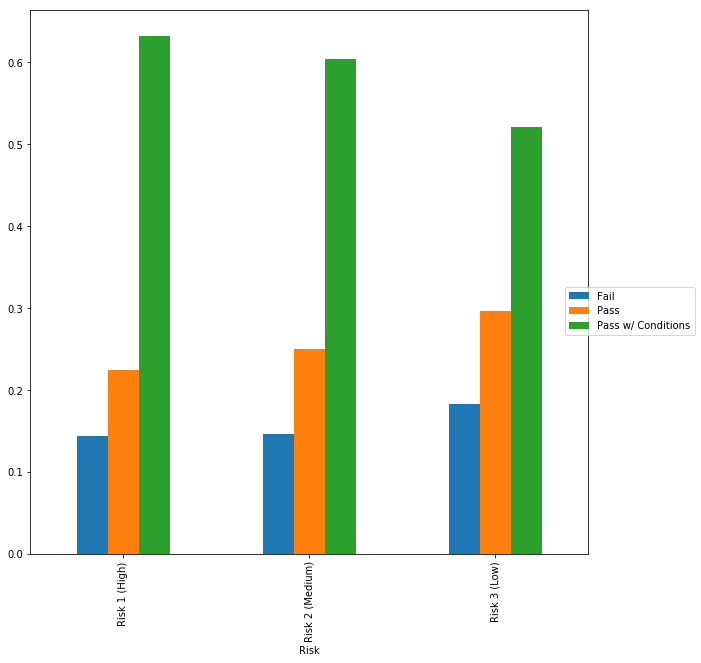

In [20]:
compute_plot_by_risk(chicago_new, False)

**Plot different risk level (within 10 years)**

Results,Fail,Pass,Pass w/ Conditions
Risk,,,
Risk 1 (High),0.200926,0.634423,0.164651
Risk 2 (Medium),0.214943,0.633161,0.151897
Risk 3 (Low),0.244228,0.670865,0.084907


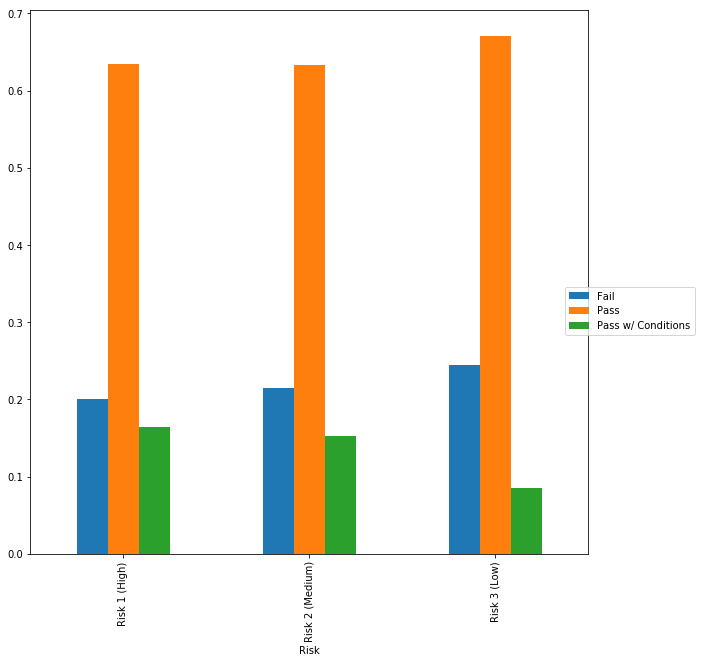

In [21]:
compute_plot_by_risk(chicago, True)

**Analysis** In general, Risk 3 (Low) performs the best as it has the lowest pass with conditions rate and highest past rate among the three categories of risk levels. 

According to Chicago Department of Public Health, the frequency of inspection is tied to this risk, with risk 1 establishments inspected most frequently and risk 3 least frequently. Risk 1 establishments are inspected twice per year,risk 2 establishments once per year, and risk 3 establishments every other year. Namely Risk 3 (Low) do have a lower risk level and it does not needs too often inspections.

## 3.2. Health-Score Metric
### 3.2.0. Helper Functions

In [136]:
def compute_risk_health(data):
    """A helper function that computes the health score for each risk level
    Args:
        data(dataframe): chicago food inspection dataset
    Returns:
        data(dataframe): health score for each risk level
    """
    data = data[['License #', 'health_score', 'Risk']].drop_duplicates()\
            .groupby('Risk').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score')
    return data

### 3.2.1. Results
**Risk level with health score (old inspection scheme)**

In [181]:
compute_risk_health(chicago_health_before).drop(['All'])

,health_score
Risk,
Risk 1 (High),48.856963
Risk 2 (Medium),56.617512
Risk 3 (Low),77.555798


**Risk level with health score (After inspection scheme)**

In [182]:
compute_risk_health(chicago_health_after).drop(['All'])

,health_score
Risk,
Risk 1 (High),51.324041
Risk 2 (Medium),59.669689
Risk 3 (Low),78.389278


**Risk level with health score (within 10 years)**

In [183]:
compute_risk_health(chicago_health).drop(['All'])

,health_score
Risk,
Risk 1 (High),47.905090
Risk 2 (Medium),57.089308
Risk 3 (Low),78.889432


**Analysis** Again, Risk 3 (Low) performs the best as it has the highest health score among the three categories of risk levels. Additionally, the higher the risk level, the lower the health score it is. Hence, it makes sense to classify these food establishements as high risk as they do deserve more often inspections for public food safety.

# 4. Analysis by Facility Type

## 4.0. Facility Type Selection

There are in total 440 facility types and we choose the top ones to perform the analysis.

In [212]:
facility_type_percent = pd.DataFrame({'count': chicago['Facility Type'].value_counts(), \
                                      'percentage':(chicago['Facility Type'].value_counts()/chicago['Facility Type'].count())*100})
facility_type_percent['cumulative percentage'] = facility_type_percent['percentage'].cumsum()
print('The total number of facility types is %d' % facility_type_percent.shape[0])
facility_type_percent.head(25)

The total number of facility types is 440


,count,percentage,cumulative percentage
restaurant,130326,68.324727,68.324727
grocery store,24908,13.058272,81.382998
school,12107,6.347217,87.730216
children's services facility,3071,1.610003,89.340219
bakery,2862,1.500433,90.840651
daycare (2 - 6 years),2688,1.409211,92.249862
daycare above and under 2 years,2366,1.240399,93.490262
long term care,1346,0.705654,94.195916
catering,1191,0.624394,94.820310
mobile food dispenser,869,0.455582,95.275892


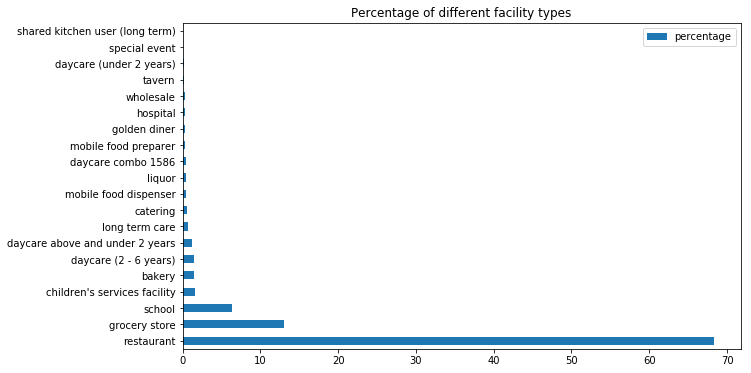

In [213]:
facility_type_percent.iloc[:20].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of different facility types')

**Observation**
1. We can obserse that we have 440 different facility types, but only the top 20 facility types have number of inspection more than 100 and constitue the 98% of the total inspection results.
2. We select the top 20 facility types and analysis them.

## 4.1. Pass-Rate Metric
### 4.1.0. Helper Function

In [214]:
def compute_plot_facilityType_rate(dataframe, topK, sortBy):
    """A helper function that computes the average pass, pass with condition and fail rate for each facility type and plot it. 
    Args:
        data(dataframe): chicago food inspection dataset
        topK(int): top number of facility type
        sortBy(str): sort by what feature
    """
    myfacilities = dataframe['Facility Type'].value_counts().index.tolist()[:topK]
    data = dataframe[dataframe['Facility Type'].isin(myfacilities)]
    Facility_Type_rate = compute_avg_rate(data,'Facility Type')
    Facility_Type_rate.sort_values(by = sortBy)\
        .plot(kind = 'bar', figsize = (10, 10))\
        .legend(bbox_to_anchor=(1.2, 0.5))

### 4.1.1. Results
**Facility types with result rate (within 10 years)**

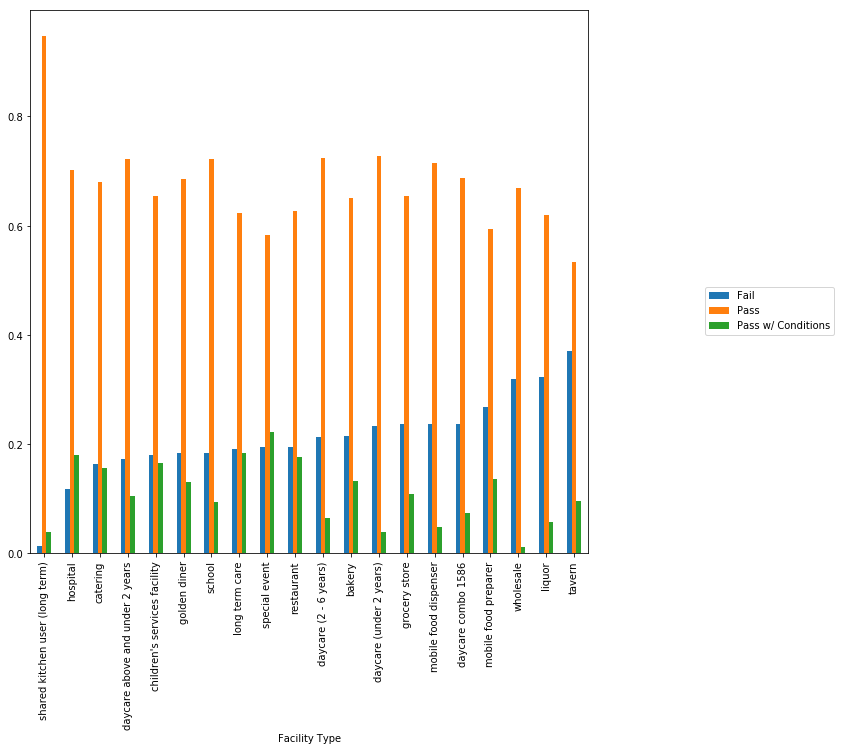

In [29]:
compute_plot_facilityType_rate(chicago,20, 'Fail')

**Facility types with result rate (old inspection scheme)**

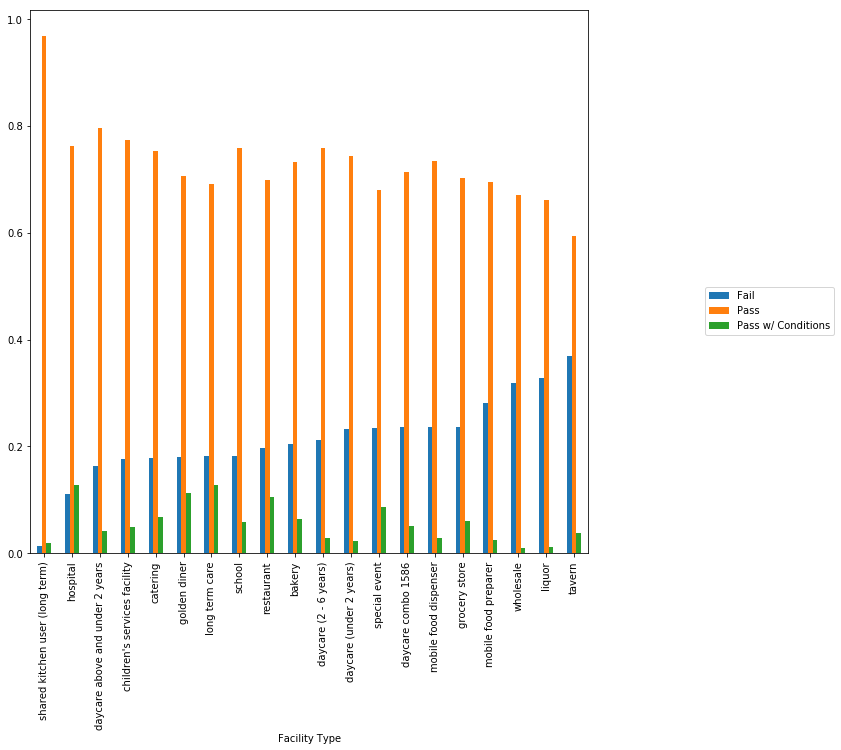

In [30]:
# Before 2018
compute_plot_facilityType_rate(chicago_old,20, 'Fail')

**Facility types with result rate (new inspection scheme)**

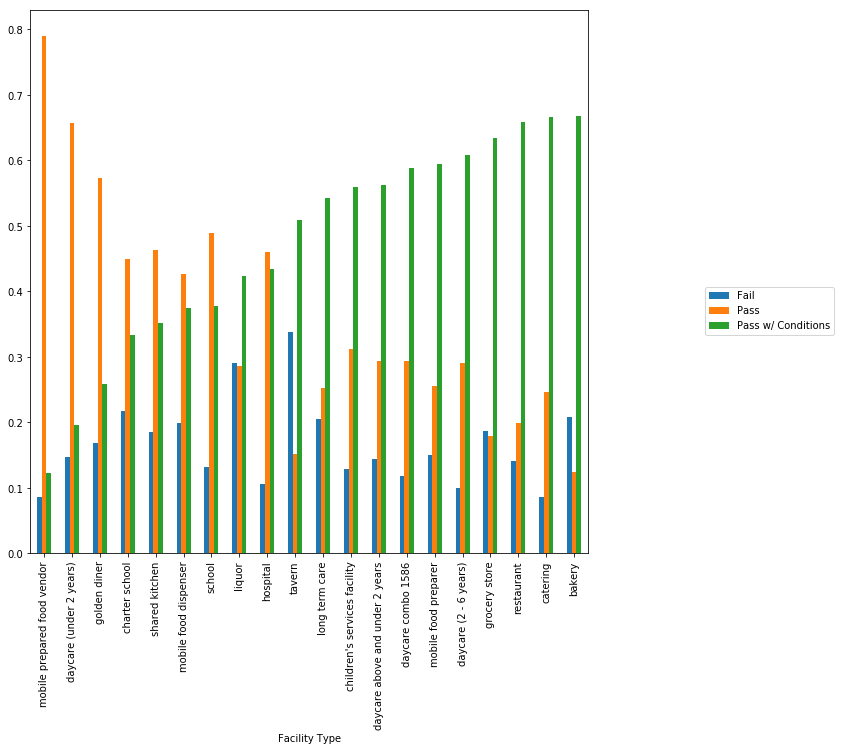

In [31]:
compute_plot_facilityType_rate(chicago_new,20, 'Pass w/ Conditions')

**Analysis** We observe that facility types that are related to special-group care (eg. hospital, daycare (2-6 years), children's services facility) and pre-prepared food (catering, mobile prepared food vendor and etc.) are in general cleaner than others. This makes sense as these sepcial groups do require a stricter food hygiene standard. Also, the pre-preapred food are usally well-packed in a center kitchen with industrial standards and hence would outperform independent restaurants.

## 4.2. Health-Score Metric
### 4.2.0. Helper Functions

In [215]:
def compute_facilityType_healthScore(dataframe,topK):
    """A helper function that computes the health score for different facility type
    Args:
        data(dataframe): chicago food inspection dataset
        topK(int): top number of facility type
    Returns:
        facility_health_score(dataframe): health score for topK facility type
    """
    myfacilities = dataframe['Facility Type'].value_counts().index.tolist()[:topK]
    facility_health_score = dataframe[(dataframe['Facility Type'].isin(myfacilities)) & (dataframe['License #'] > 0)]\
            [['License #', 'health_score', 'Facility Type']].drop_duplicates()\
            .groupby('Facility Type').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score', ascending = False)
    
    return facility_health_score
    

### 4.2.1. Results
**Facility types with health_score (old inspection scheme)**

In [216]:
compute_facilityType_healthScore(chicago_health_before,20)

,health_score
Facility Type,
shared kitchen user (long term),97.749111
mobile food dispenser,82.602192
liquor,64.290317
catering,62.789936
wholesale,62.265319
mobile food preparer,62.224832
golden diner,60.755312
daycare (2 - 6 years),59.250899
daycare (under 2 years),58.886929


**Facility types with health_score (new inspection scheme)**

In [217]:
compute_facilityType_healthScore(chicago_health_after,20)

,health_score
Facility Type,
mobile prepared food vendor,90.258041
pop-up establishment host-tier ii,82.512985
mobile food dispenser,75.736362
daycare (under 2 years),74.148533
school,68.950980
hospital,68.633299
golden diner,67.638995
charter school,67.604444
daycare (2 - 6 years),66.225866


**Facility types with health_score (wiyj 10 years)**

In [218]:
compute_facilityType_healthScore(chicago_health,20)

,health_score
Facility Type,
mobile food dispenser,83.423385
liquor,66.289103
wholesale,65.593281
daycare (under 2 years),61.822485
catering,61.455186
mobile food preparer,60.387153
grocery store,59.969146
daycare combo 1586,59.868739
daycare (2 - 6 years),59.341711


## Part B violation related analysis
In this part we analysis the violations 

1. The City of Chicago has adopted a new food code rules to better ensure food safety after July 1, 2018 . We generate two Regulation tables **Regulation_old** and **Regulation_new** from the original chicago dataset, each contains two fields **Regulation Series Number** and **Regulation Content**

2. Is there a pattern of **Inspection types** w.r.t. violations? Can we calssify them? For each class of inspection types, find the violations that occurs very often and analysis the reasons.

3. Is there a pattern of **Facility types** w.r.t. violations? For each facility type selected, find the violations that occurs very often and analysis the reasons.

4. Calculate the recurrence rate of each regulation and study its relationship with the occurrence percentage. Then we select some important regulations that both recurrance rate and occurrence percentage are high to do the question 5.

5. For each of the important regulations we selected from 4, generate a word cloud of the Corresponding comments.



## 1. preprocess the data to generate the new table for analysis

In [11]:
# the columns we needed for violation related analysis is below
columns_needed = ['License #', 'Facility Type', 'Inspection Date', 'Inspection Type', 'Violations']

In [12]:
chicago_all = chicago[columns_needed].copy()

# Ignore all the rows that have missing values (NaNs) in the Violations field
chicago_all = chicago_all[chicago_all.Violations.isnull()==False]

# Split the Violation field using delimiter “|” 
chicago_all['Violations'] = chicago_all.Violations.apply(lambda x: x.split("| "))

# Expand the Violations field using the Pandas method explode()
chicago_exploded = chicago_all.explode('Violations')\
                              .rename(columns={'Violations':'Violation'})\
                              .reset_index(drop=True) \
                              .dropna(subset=['Violation'])
chicago_exploded.head(3)

,License #,Facility Type,Inspection Date,Inspection Type,Violation
0,2529116,restaurant,2019-11-08,canvass re-inspection,"3. management, food employee and conditional e..."
1,2529116,restaurant,2019-11-08,canvass re-inspection,5. procedures for responding to vomiting and d...
2,2529116,restaurant,2019-11-08,canvass re-inspection,58. allergen training as required - comments: ...


In [13]:
## Store the Regulation Number in a new field
chicago_exploded['Regulation Series Number'] = chicago_exploded.Violation.apply(lambda x: 'R'+x.split(".")[0])

# Store the Regualtion of the corresponding Violation Number in a new filed
chicago_exploded['Regulation Content'] = chicago_exploded.Violation.apply(lambda x: x.split(" - comments: ")[0].strip())

# Store the comment of the corresponding Violation Number in a new field
chicago_exploded['Comment'] = chicago_exploded.Violation.apply(lambda x: x.split("comments: ")[-1].strip())
chicago_exploded.head(3)

,License #,Facility Type,Inspection Date,Inspection Type,Violation,Regulation Series Number,Regulation Content,Comment
0,2529116,restaurant,2019-11-08,canvass re-inspection,"3. management, food employee and conditional e...",R3,"3. management, food employee and conditional e...",2-102.14(o) observed no written employee heal...
1,2529116,restaurant,2019-11-08,canvass re-inspection,5. procedures for responding to vomiting and d...,R5,5. procedures for responding to vomiting and d...,2-501.11 observed no clean up procedure and s...
2,2529116,restaurant,2019-11-08,canvass re-inspection,58. allergen training as required - comments: ...,R58,58. allergen training as required,2-102.13 observed the certified food manager ...


The City of Chicago has adopted a new food code rules to better ensure food safety according to this website https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/understand_healthcoderequirementsforfoodestablishments.html. For all inspections completed after July 1, 2018 the Chicago Department of Public Health uses the new rules. So we split the table we generated above to two tables, one contains the inspections before the change of the rules and the other contains the inspections after the change of the rules.

In [14]:
chicago_before = chicago_exploded[chicago_exploded['Inspection Date'] < datetime(2018, 7, 1)].copy()
chicago_after = chicago_exploded[chicago_exploded['Inspection Date'] >= datetime(2018, 7, 1)].copy()

**Generate a Regulation table contains the old food code rules**

In [15]:
# select two fields `Regulation Series Number` and `Regulation Content`
Regulation = chicago_before[['Regulation Series Number', 'Regulation Content']]

# Drop the duplicated rows
Regulation_old = Regulation.drop_duplicates().copy()

# sort the table according to the Regulation Number
Regulation_old['Regulation_Rank'] = [int(s[1:]) for s in Regulation_old['Regulation Series Number']]
Regulation_old = Regulation_old.sort_values(by=['Regulation_Rank']).reset_index(drop=True)[['Regulation Series Number', 'Regulation Content']]
Regulation_old

,Regulation Series Number,Regulation Content
0,R1,"1. source sound condition, no spoilage, foods ..."
1,R2,2. facilities to maintain proper temperature
2,R3,3. potentially hazardous food meets temperatur...
3,R4,4. source of cross contamination controlled i....
4,R5,5. personnel with infections restricted: no op...
5,R6,"6. hands washed and cleaned, good hygienic pra..."
6,R7,7. wash and rinse water: clean and proper temp...
7,R8,8. sanitizing rinse for equipment and utensils...
8,R9,"9. water source: safe, hot & cold under city p..."
9,R10,"10. sewage and waste water disposal, no back s..."


**Generate a Regulation table contains the new food code rules after July 1, 2018**

In [16]:
# select two fields `Regulation Series Number` and `Regulation Content`
Regulation = chicago_after[['Regulation Series Number', 'Regulation Content']]

# Drop the duplicated rows
Regulation_new = Regulation.drop_duplicates().copy()

# sort the table according to the Regulation Number
Regulation_new['Regulation_Rank'] = [int(s[1:]) for s in Regulation_new['Regulation Series Number']]
Regulation_new = Regulation_new.sort_values(by=['Regulation_Rank']).reset_index(drop=True)[['Regulation Series Number', 'Regulation Content']]
Regulation_new

,Regulation Series Number,Regulation Content
0,R1,"1. person in charge present, demonstrates know..."
1,R2,2. city of chicago food service sanitation cer...
2,R3,"3. management, food employee and conditional e..."
3,R4,4. proper use of restriction and exclusion
4,R5,5. procedures for responding to vomiting and d...
...,...,...
58,R59,59. previous priority foundation violation cor...
59,R60,60. previous core violation corrected
60,R61,61. summary report displayed and visible to th...
61,R62,62. compliance with clean indoor air ordinance


## 2. Inspection Type
## Is there a pattern of Inspection types w.r.t. violations?

The column *'Inspection Type'* contains different inspection types. Before we start, we want to show the percentage of different inspection types.

In [17]:
inspection_type_percent = pd.DataFrame({'count': chicago_all['Inspection Type'].value_counts(),\
                                        'percentage':(chicago_all['Inspection Type'].value_counts()/chicago_all['Inspection Type'].count())*100})
inspection_type_percent['cumulative percentage'] = inspection_type_percent['percentage'].cumsum()
print('>>>>>>>>>>>>>>>The total number of inspection types is %d<<<<<<<<<<<<<<<<<<<<' % inspection_type_percent.shape[0])
inspection_type_percent.head(10)

>>>>>>>>>>>>>>>The total number of inspection types is 54<<<<<<<<<<<<<<<<<<<<


,count,percentage,cumulative percentage
canvass,78977,54.977237,54.977237
complaint,16980,11.820068,66.797305
license,15910,11.075222,77.872527
canvass re-inspection,14888,10.363791,88.236318
complaint re-inspection,5373,3.740237,91.976555
short form complaint,4903,3.413062,95.389617
license re-inspection,3819,2.658471,98.048088
suspected food poisoning,818,0.569424,98.617512
tag removal,495,0.344578,98.962089
consultation,394,0.274270,99.236360


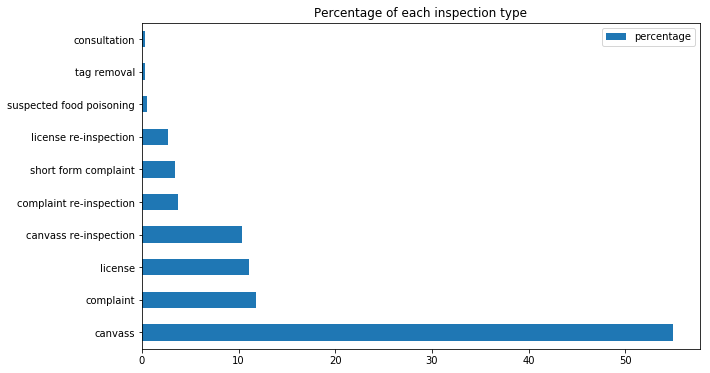

In [18]:
# show the top10 inspection types
inspection_type_percent.iloc[:10].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of each inspection type')
plt.show()

**Observation**
1. We can observe that we have 54 different inspection types, but only the top 7 inspection types have percentage more than 1% and constitue 98% of the total inspection results.
2. We select the top 7 inspection types and analysis them in the later stage.

In [19]:
# select the top 7 inspection types
selected_inspection_type = inspection_type_percent.where(inspection_type_percent['percentage'] >= 1).dropna().index.tolist()
print("Our selected inspection type is\n", selected_inspection_type)

Our selected inspection type is
 ['canvass', 'complaint', 'license', 'canvass re-inspection', 'complaint re-inspection', 'short form complaint', 'license re-inspection']


In [20]:
def get_stats_info(valid_type, original_table, type_, old):
    """get the statistic results of different inspection/facility types in terms of different inspection regulations
    Args:
        valid_type: inspection/facility types that we selected
        original_table : the table contains all the inspection/facility types
        type_: the field on which we want to do the statistics (inspection/facility type)
        old: use Regulation_old or use Regulation_new
    Returns:
        stats: the number of violations w.r.t each inspection regulation for different inspection/facility types
        stats_percentage: the percentage of vialations w.r.t each inspection regulation for different inspection/facility type
        stats_percentage_sorted: dataframe with each row being the sorted percentage and regulation series number  
    """
    # select rows with inspection/facilty type in the valid_type
    valid_table = original_table[original_table[type_].isin(valid_type)]
    
    # count the number of violations of each inspection regulation for different inspection/facility types.
    stats = valid_table.groupby(type_)['Regulation Series Number']\
                       .apply(lambda x: x.value_counts())\
                       .unstack()\
                       .fillna(0.0)
    # sort the row according to the valid_type sequence
    stats =stats.loc[valid_type, :]
    
    # sort the column according to the Regulation series number(this step make the table much more readable)
    if old:
        stats= stats.reindex(Regulation_old['Regulation Series Number'], axis=1)
    else:
        stats= stats.reindex(Regulation_new['Regulation Series Number'], axis=1)
        
    # add a row to record the sum of occurrences of different types for each violation
    stats.loc['total'] = stats.sum(axis=0)
    
    # get the percentage of vialations with respect to each inspection regulation for different inspection/facility type
    stats_percentage = stats.apply(lambda x: round((x/x.sum())*100, 3), axis=1)
    # get the sorted version
    column = stats_percentage.columns.values
    y = [list(zip(stats_percentage.loc[y], column)) for y in valid_type]
    [x.sort(reverse=True) for x in y]
    stats_percentage_sorted = pd.DataFrame(y, index=valid_type)
    stats_percentage_sorted.columns.rename('Rank', inplace=True)
    
    return stats[:-1], stats_percentage[:-1], stats_percentage_sorted

In [21]:
# get statistic result for valid facilty before changing food rules
stats_inspection_old, stats_percentage_inspection_old, stats_percentage_sorted_inspection_old\
    = get_stats_info(selected_inspection_type, chicago_before, 'Inspection Type', old=True)

# get statistic result for valid facilty after changing food rules
stats_inspection_new, stats_percentage_inspection_new, stats_percentage_sorted_inspection_new\
    = get_stats_info(selected_inspection_type, chicago_after, 'Inspection Type', old=False)

**Below we show the total number of violations of each old regulation (before July 1 2018) for different inspection types.**

In [22]:
stats_inspection_old.head(3)

Regulation Series Number,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R37,R38,R39,R40,R41,R42,R43,R44,R45,R70
Inspection Type,,,,,,,,,,,,,,,,,,,,,
canvass,324.0,3037.0,5879.0,282.0,8.0,1088.0,79.0,1558.0,556.0,328.0,...,3119.0,29553.0,417.0,8414.0,18082.0,4087.0,5170.0,231.0,4546.0,255.0
complaint,213.0,1059.0,2314.0,161.0,6.0,566.0,27.0,512.0,220.0,128.0,...,732.0,6619.0,108.0,2042.0,4476.0,1102.0,1318.0,54.0,990.0,111.0
license,52.0,1643.0,220.0,16.0,0.0,25.0,19.0,373.0,607.0,239.0,...,1661.0,6783.0,17.0,1867.0,3779.0,159.0,218.0,25.0,225.0,128.0


**Below we show the percentage of vialations of each regulation (after July 1 2018) for different inspection/facility type**

In [23]:
stats_percentage_inspection_old.head(3)

Regulation Series Number,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R37,R38,R39,R40,R41,R42,R43,R44,R45,R70
Inspection Type,,,,,,,,,,,,,,,,,,,,,
canvass,0.111,1.038,2.009,0.096,0.003,0.372,0.027,0.532,0.190,0.112,...,1.066,10.100,0.143,2.875,6.180,1.397,1.767,0.079,1.554,0.087
complaint,0.280,1.393,3.044,0.212,0.008,0.744,0.036,0.673,0.289,0.168,...,0.963,8.706,0.142,2.686,5.888,1.450,1.734,0.071,1.302,0.146
license,0.097,3.072,0.411,0.030,0.000,0.047,0.036,0.697,1.135,0.447,...,3.106,12.684,0.032,3.491,7.066,0.297,0.408,0.047,0.421,0.239


**So which Regulations play the most significan roles in different insepction types?**

Here we sort the regulations in the dataframe above with the column index being the rank of the regulation in a specific inspection type. Each cell is a tuple, where the first element is the **percentage of occurences** and the second one is the **regulation series number**.

In [24]:
stats_percentage_sorted_inspection_old.head(3)

Rank,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
canvass,"(14.073, R34)","(12.95, R33)","(12.129, R35)","(10.36, R32)","(10.1, R38)","(6.18, R41)","(4.774, R36)","(3.478, R30)","(2.875, R40)","(2.872, R18)",...,"(0.076, R27)","(0.073, R13)","(0.029, R25)","(0.029, R17)","(0.027, R7)","(0.015, R14)","(0.008, R20)","(0.003, R5)","(0.001, R23)","(0.0, R15)"
complaint,"(13.678, R34)","(12.213, R33)","(11.321, R35)","(9.711, R32)","(8.706, R38)","(5.888, R41)","(4.568, R36)","(4.139, R18)","(3.181, R30)","(3.044, R3)",...,"(0.071, R44)","(0.063, R25)","(0.049, R27)","(0.037, R17)","(0.036, R7)","(0.021, R14)","(0.016, R20)","(0.008, R5)","(0.003, R23)","(0.001, R15)"
license,"(12.684, R38)","(12.654, R35)","(11.072, R34)","(9.912, R32)","(7.616, R33)","(7.066, R41)","(6.113, R18)","(5.09, R36)","(3.491, R40)","(3.106, R37)",...,"(0.036, R7)","(0.032, R39)","(0.032, R25)","(0.03, R4)","(0.019, R28)","(0.004, R17)","(0.002, R23)","(0.002, R14)","(0.0, R5)","(0.0, R15)"


### Are there similarities between inspection types? Can we classify them?
**We calculate the correlation between different inspection types (use the percentage of each violation number) and plot the heatmap**

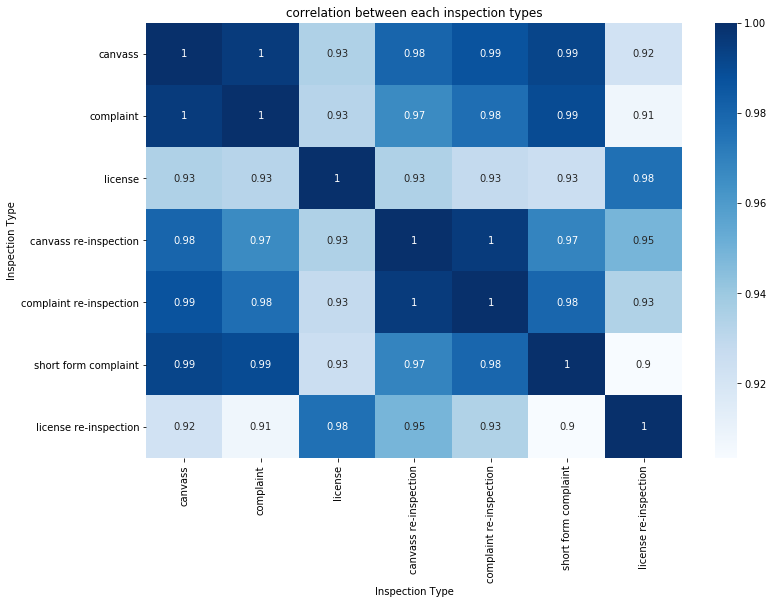

In [25]:
# concatenate the data before and after the change of inspection rules.
# we have 46 inspection rules(1-45 and 70) before change and 63 inspection rule(1-63) after change. After concatenate we have 109 columns.
stats_inspection_concat = pd.concat([stats_inspection_old, stats_inspection_new], axis=1)
stats_inspection_concat = stats_inspection_concat.fillna(0.0)
stats_inspection_concat = stats_inspection_concat.apply(lambda x: round((x/x.sum())*100, 2), axis=1)

# plot the correlation between each inspection types
plt.figure(figsize=(12,8))
corr = stats_inspection_concat.transpose().corr()
sns.heatmap(corr,annot=True,cmap=plt.cm.Blues)
plt.title("correlation between each inspection types")
plt.show()

**Observation**
1. We can observe the correlation between `license` and `license re-inspection` is 0.98, while the correlation between `license`/`license re-inspection` and other inspection type is around 0.92, a liitle bit smaller than 0.98.
3. The correlation between [`canvass`, `canvass re-inspection`, `complaint`, `short form complaint`, `complaint re-inspection`] is around 0.98.
4. We can roughly say that [`license`, `license re-inspection`] is class **"License-Inspection"**, and [`canvass`, `canvass re-inspection`, `complaint`, `short form complaint`, `complaint re-inspection`] is another class **"Non-License-Inspection"**. We use K-means to verify them

In [26]:
def K_mean_func(data, max_k):
    """get the K-means clustering results for a given data. 
       Draw clustering renderings with different K values to find the best K value.
    Args:
        data: data that needs to be clustered
        max_k : run k-means for different values of ‘K’, from 1 to max_k. 
    """
    SSE = []
    X = []
    
    for i in range(max_k):
        # Clustering 
        kms = KMeans(n_clusters = i + 1)
        predicted_labels = kms.fit_predict(data)
        
        # Output clustering results
        print("K(number of clusters):", i + 1)
        for j in range(i + 1):
            print("class %d: %s" % (j + 1, np.where(predicted_labels == j)[0]))
        print()
        
        # save the cluster's inertia
        SSE.append(kms.inertia_)
        X.append(i + 1)
        
    # Draw inertia plots with different K values
    plt.xlabel('K')
    plt.ylabel('The sum of squared errors (SSE)')
    plt.title('The sum of squared errors (SSE) of different number of k')
    plt.plot(X,SSE,'o-')
    plt.show()

K(number of clusters): 1
class 1: [0 1 2 3 4 5 6]

K(number of clusters): 2
class 1: [0 1 3 4 5]
class 2: [2 6]

K(number of clusters): 3
class 1: [3 4]
class 2: [2 6]
class 3: [0 1 5]

K(number of clusters): 4
class 1: [0 1]
class 2: [2 6]
class 3: [3 4]
class 4: [5]

K(number of clusters): 5
class 1: [3 4]
class 2: [2]
class 3: [0 1]
class 4: [5]
class 5: [6]



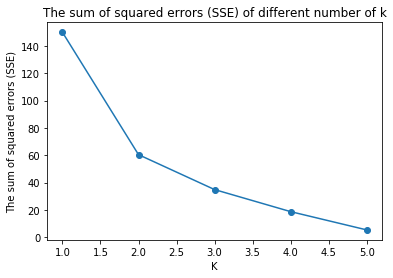

In [27]:
# The data point label and the corresponding inspection type
dict_ = {0:'canvass', 
         1:'complaint', 
         2:'license', 
         3:'canvass re-inspection', 
         4:'complaint re-inspection', 
         5:'short form complaint', 
         6:'license re-inspection'}
K_mean_func(stats_inspection_concat.values, 5)

**Observation**  
As we can see in the graph there is a rapid drop in SSE as we move from K=1 to 2 and it becomes almost constant as the value of K is further increased. So the value to be considered for K is 2. This is also coincide with the conclusion we draw from the correaltion heapmap for different inspection types. 

So in the following analysis we combine `[2:'license',6:'license re-inspection']` as a class named **"License-Inspection"**, and `[0:'canvass', 1:'complaint', 3:'canvass re-inspection', 4:'complaint re-inspection', 5:'short form complaint']` as another class named **" Non-License-Inspection"**.

### For each class of inspection types, find the violations that occurs very often and analysis the reasons

Here we have two class of inspection types. One is **License-Inspection** which contains inspection type: license and license re-inspection, the other is **Non-License-Inspection** which contains inspection type: canvass, complaint, canvass re-inspection, complaint re-inspection, short form complaint. For this two class we want to find whether there is some violations appears more often than the other.

In [28]:
def plot_scatter(data, x_index, y_index, x_label, y_label, title, text_size, add_line):
    """Scatter plot for given data.
    Args:
        data: original data.
        x_index: the index of the inspection types in the same class
        y_index: the index of the inspection types in another class
        x_label: X label of the plot
        y_label: Y label of the plot
        title: the title of the plot
        text_size: parameter related to the text annotation in the plot
        add_line (Boolean): whether to add a reference line "y=x"
    """
    
    # Pick data and clean up
    # we calculate the 
    x_data = data.iloc[x_index, :]
    x_data= x_data.apply(lambda x: x.sum(),axis = 0)
    sum_x_data = np.sum(x_data)
    x_data = x_data/sum_x_data
    
    y_data = data.iloc[y_index, :]
    y_data= y_data.apply(lambda x: x.sum(),axis = 0)
    sum_y_data = np.sum(y_data)
    y_data = y_data/sum_y_data
    
    # create the data tag
    text = x_data._stat_axis.values.tolist()
    
    # Draw picture
    plt.figure(figsize=(8,6))
    plt.scatter(x_data, y_data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # add data tag in some important data point
    for i in range(len(x_data)):
        if(x_data[i] >= text_size[0]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(y_data[i] >= text_size[1]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(x_data[i] - y_data[i] >= text_size[5]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(y_data[i] - x_data[i] >= text_size[6]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
    if(add_line == True):
        plt.plot([0, text_size[4]],[0, text_size[4]], label = "y = x", color='r')
    plt.legend()
    plt.show()

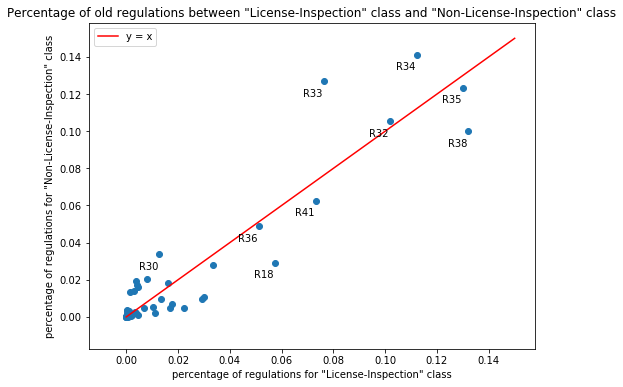

In [29]:
x_index = [2, 6] # License-Inpection class
y_index = [0, 1, 3, 4, 5] # Non-License-inspection class
x_label = 'percentage of regulations for "License-Inspection" class'
y_label = 'percentage of regulations for "Non-License-Inspection" class'
title = 'Percentage of old regulations between "License-Inspection" class and "Non-License-Inspection" class'
text_size = [0.05, 0.05, 0.008, 0.008, 0.15, 0.02, 0.02]
add_line = True
plot_scatter(stats_inspection_old, x_index, y_index, x_label, y_label, title, text_size, add_line)

**Analysis for Old Regulation (Before July 1 2018)**

Here we plot a scatter figure with each point represent specific type of old regulations (before July 1 2018), the x value of the point represents the occurance percentage of this regulation in **License-Inspection** class, and the y value of the point represents the occurance percentage of this regulation in **Non-License-Inspection**class. We can observe that the regulations **R18** and **R38** occurs more often in the **License-Inspection** class than the **Non-License-Inspection** class, while the Regulations **R33** and **R34** occurs more often in the **Non-License-Inspection**. 

Here we check the regulation contents  
Occurs more often in **License-Inspection** class  
>R18: no evidence of rodent or insect outer openings protected/rodent proofed, a written log shall be maintained available to the inspectors\
>R38: ventilation: rooms and equipment vented as required: plumbing: installed and maintained\

Occurs more often in **Non-License-Inspection** class
>R33: food and non-food contact equipment utensils clean, free of abrasive detergents\
>R34: floors: constructed per code, cleaned, good repair, coving installed, dust-less cleaning methods used

Then, we look at the specific content of the Comment for more information

**Observation under the old regulation(before July 1, 2018)**  
we look at the specific content of the Comment for more information. We can observe that:   

The main problem of R18 is the discovery of harmful pests such as mice, small, flies, fruit fly, droppings, roaches and their feces.  
The main problems of R38 are equipment problems such as leaking pipes, lack of ventilation and exposure of sinks.

The main problems of R33 are cleaning problems such as grease, disinfection, and dirty food.  
The main problem of R34 are floor cleaning problems such as the floor is not clean, the floor is missing, and there is water on the floor.

Combining the above four points, we analyze: For an establishment that applies for License, they will pay more attention to the cleaning problem, so the cleaning problem is relatively small, but the new store will not be mature enough for pest control and facility construction, so the problems in these areas are dominant.

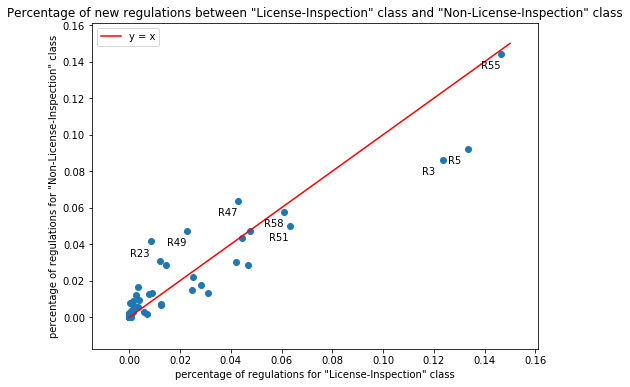

In [30]:
x_index = [2, 6]
y_index = [0, 1, 3, 4, 5]
x_label = 'percentage of regulations for "License-Inspection" class'
y_label = 'percentage of regulations for "Non-License-Inspection" class'
title = 'Percentage of new regulations between "License-Inspection" class and "Non-License-Inspection" class'
text_size = [0.05, 0.05, 0.008, 0.008, 0.15, 0.02, 0.02]
add_line = True
plot_scatter(stats_inspection_new, x_index, y_index, x_label, y_label, title, text_size, add_line)

**Analysis for New Regulation (After July 1 2018)**

Here we plot a scatter figure with each point represent specific type of new regulation (after July 1 2018), the x value of the point represents the occurance percentage of this regulation in **License-Inspection** class, and the y value of the point represents the occurance percentage of this regulation in **Non-License-Inspection**class. We can observe that the regulations **R3** and **R5** occurs more often in the **License-Inspection** class than the **Non-License-Inspection** class, while the Regulations **R23**, **R47** and **R49** occurs more often in the **Non-License-Inspection**. 

Here we check the regulation contents  
Occurs more often in **License-Inspection** class  
>R3  management, food employee and conditional employee; knowledge, responsibilities and reporting\
>R5  procedures for responding to vomiting and diarrheal events\

Occurs more often in **Non-License-Inspection** class
>R23  proper date marking and disposition\
>R47  food & non-food contact surfaces cleanable, properly designed, constructed & used\
>R49  non-food/food contact surfaces clean\

**Observation under the new regulation(after July 1, 2018)**  
we look at the specific content of the Comment for more information. We can observe that:      
The main problem of R3 is no employee health policy.  
The main problems of R5 are no plan for responding to vomiting and diarrheal and lack of equipment such as cleaning kits.

The main problems of R23 is date marking.  
The main problem of R47 are cleaning problems such as fouling, stains, grease.  
The main problem of R49 are floor cleaning problems such as stove, oven, floors are not clean.

Combining the above five points, we analyze: For a stores that applies for License, they will pay more attention to the cleaning problem, so the cleaning problem is relatively small, However, because the new store is not mature enough, they are relatively poor on employee health policy, plan for responding to vomiting and diarrheal, date marking problems.

Based on the above analysis, associating with the actual content of each regulation, we can conclude that **License-Inspection** emphasises more on equipment-realted, planning-related and prevention-work-related problems. On the other hand, **Non-License-Inspection** emphasises more on cleaning-related problems.

## 3. Facility type

## Is there a pattern of facility types w.r.t. violations?

Plot the percentage of the different facility types and select the facility types that makes up the most of the inspections to do further analysis. For each facility type, find the violations that occurs very often and analysis the reasons. Whether there are some similarities and differences between these facility types in terms of the violations that easily violated.

**Determine major facility type**

The column *'Facility Type'* contains different facility types. Before we start, we want to show the percentage of different facility types.

In [31]:
facility_type_percent = pd.DataFrame({'count': chicago_all['Facility Type'].value_counts(), \
                                      'percentage':(chicago_all['Facility Type'].value_counts()/chicago_all['Facility Type'].count())*100})
facility_type_percent['cumulative percentage'] = facility_type_percent['percentage'].cumsum()
print('>>>>>>The total number of facility types is %d>>>>>>>>>' % facility_type_percent.shape[0])
facility_type_percent.head()

>>>>>>The total number of facility types is 383>>>>>>>>>


,count,percentage,cumulative percentage
restaurant,98631,68.717081,68.717081
grocery store,18019,12.553995,81.271075
school,10636,7.410194,88.681270
children's services facility,2362,1.645626,90.326896
bakery,2172,1.513251,91.840147


**Plot the percentage of facility type**

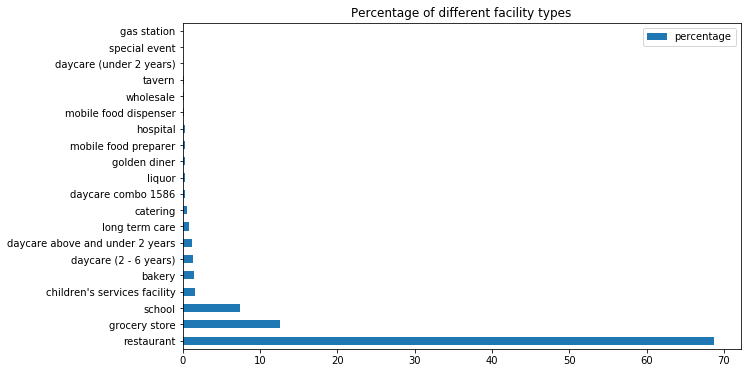

In [32]:
facility_type_percent.iloc[:20].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of different facility types')
plt.show()

**Observation**
1. We can obserse that we have 383 different facility types, but only the top 20 facility types have number of inspection more than 100 and constitue the 98% of the total inspection results.
2. We select the top 20 facility types and analysis them.

In [33]:
selected_facility_type = facility_type_percent.where(facility_type_percent['count'] >= 100).dropna().index.tolist()
print("Our selected facility types are: \n", selected_facility_type)

Our selected facility types are: 
 ['restaurant', 'grocery store', 'school', "children's services facility", 'bakery', 'daycare (2 - 6 years)', 'daycare above and under 2 years', 'long term care', 'catering', 'daycare combo 1586', 'liquor', 'golden diner', 'mobile food preparer', 'hospital', 'mobile food dispenser', 'wholesale', 'tavern', 'daycare (under 2 years)', 'special event', 'gas station']


In [34]:
# get statistic result for valid facilty before the change of food rules
stats_facility_old, stats_percentage_facility_old, stats_percentage_sorted_facility_old\
    = get_stats_info(selected_facility_type, chicago_before, 'Facility Type', old=True)

# get statistic result for valid facilty after the change of food rules
stats_facility_new, stats_percentage_facility_new, stats_percentage_sorted_facility_new\
    = get_stats_info(selected_facility_type, chicago_after, 'Facility Type', old=False)

Here we sort the regulations with the column index being the rank of the regulation in a specific facility type. Each cell is a tuple, where the first element is the **percentage of occurences** and the second one is the **regulation series number**. The regulation_table we use is the **old** one.

In [35]:
stats_percentage_sorted_facility_old.head(3)

Rank,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
restaurant,"(13.386, R34)","(12.632, R33)","(11.72, R35)","(10.929, R32)","(9.809, R38)","(5.534, R41)","(4.69, R36)","(3.71, R30)","(2.9, R40)","(2.87, R18)",...,"(0.088, R70)","(0.075, R44)","(0.04, R27)","(0.031, R25)","(0.03, R17)","(0.028, R7)","(0.014, R20)","(0.004, R5)","(0.001, R23)","(0.001, R15)"
grocery store,"(14.715, R34)","(12.567, R35)","(11.196, R33)","(9.835, R32)","(9.829, R38)","(8.781, R41)","(5.445, R36)","(4.297, R18)","(3.491, R40)","(2.083, R37)",...,"(0.078, R27)","(0.066, R4)","(0.052, R44)","(0.048, R20)","(0.045, R25)","(0.034, R7)","(0.011, R17)","(0.0, R5)","(0.0, R23)","(0.0, R15)"
school,"(17.47, R35)","(16.466, R38)","(15.054, R34)","(9.547, R33)","(9.273, R32)","(8.5, R41)","(6.04, R36)","(3.538, R18)","(1.562, R40)","(1.459, R26)",...,"(0.031, R4)","(0.025, R25)","(0.022, R7)","(0.019, R70)","(0.019, R17)","(0.006, R1)","(0.003, R5)","(0.003, R20)","(0.0, R23)","(0.0, R15)"


Here we sort the regulations with the column index being the rank of the regulation in a specific facility type. Each cell is a tuple, where the first element is the **percentage of occurences** and the second one is the **regulation series number**. The regulation_table we use is the **new** one.

In [36]:
stats_percentage_sorted_facility_new.head(3)

Rank,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
restaurant,"(13.214, R55)","(9.104, R5)","(8.934, R3)","(7.362, R58)","(6.194, R47)","(4.772, R51)","(4.407, R49)","(4.35, R10)","(4.277, R23)","(4.132, R56)",...,"(0.011, R17)","(0.008, R4)","(0.008, R31)","(0.005, R42)","(0.005, R12)","(0.002, R7)","(0.002, R27)","(0.002, R18)","(0.001, R26)","(0.0, R34)"
grocery store,"(17.164, R55)","(11.21, R5)","(8.753, R3)","(7.443, R47)","(5.408, R51)","(5.246, R49)","(4.753, R10)","(4.699, R56)","(4.161, R38)","(3.444, R36)",...,"(0.009, R31)","(0.009, R24)","(0.009, R18)","(0.0, R7)","(0.0, R63)","(0.0, R42)","(0.0, R30)","(0.0, R27)","(0.0, R26)","(0.0, R12)"
school,"(22.821, R55)","(12.85, R10)","(10.637, R51)","(9.411, R5)","(6.185, R38)","(5.998, R56)","(5.279, R3)","(4.612, R47)","(3.386, R49)","(2.426, R53)",...,"(0.0, R30)","(0.0, R29)","(0.0, R27)","(0.0, R26)","(0.0, R24)","(0.0, R20)","(0.0, R18)","(0.0, R14)","(0.0, R13)","(0.0, R11)"


**Due to the large amount of data, we use K-means for clustering directly**

Concat the number of different "Violations Number" occurrences before and after revision the rule. We can get 109 different Violations. Calculate the percentage of each Violations for Facility Type and Inspection Type.

Due to the large amount of data, we use K-means for clustering directly.

In [37]:
# concatenate the data before and after the change of inspection rules.
# we have 46 inspection rules(1-45 and 70) before change and 63 inspection rule(1-63) after change. After concatenate we have 109 columns.
stats_facility_concat = pd.concat([stats_facility_old, stats_facility_new], axis=1)
stats_facility_concat = stats_facility_concat.fillna(0.0)
stats_facility_concat = stats_facility_concat.apply(lambda x: round((x/x.sum())*100, 2), axis=1)

K(number of clusters): 1
class 1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

K(number of clusters): 2
class 1: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19]
class 2: [12 14]

K(number of clusters): 3
class 1: [ 0  3  4  7  8 13 18]
class 2: [ 1  2  5  6  9 10 11 15 16 17 19]
class 3: [12 14]

K(number of clusters): 4
class 1: [ 2  5  6  9 15 17 19]
class 2: [12 14]
class 3: [10 16]
class 4: [ 0  1  3  4  7  8 11 13 18]

K(number of clusters): 5
class 1: [ 0  1  3  4  7  8 11 13]
class 2: [14]
class 3: [ 2  5  6  9 15 17 19]
class 4: [12]
class 5: [10 16 18]

K(number of clusters): 6
class 1: [ 3  7 18]
class 2: [ 2  5  6  9 15 17 19]
class 3: [14]
class 4: [10 16]
class 5: [12]
class 6: [ 0  1  4  8 11 13]

K(number of clusters): 7
class 1: [ 2  5  9 15 17 19]
class 2: [14]
class 3: [ 0  1  4  7  8 11 13]
class 4: [18]
class 5: [10 16]
class 6: [12]
class 7: [3 6]



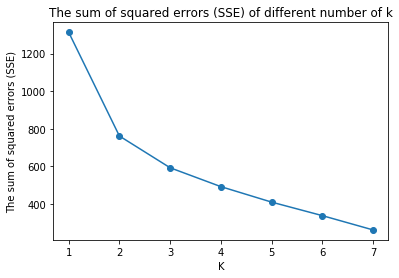

In [38]:
K_mean_func(stats_facility_concat.values, 7)

We can see that clustering works well when K = 4. The four categories are:[12, 14], [10, 16], [ 2,  5,  6,  9, 15, 17, 19], [ 0,  1,  3,  4,  7,  8, 11, 13, 18]

We can see that there are obvious differences between the four categories. 

The first category is mobile: [12, 14].

The second category is related to wine: [10, 16].

The third category is daycare, school, wholesale, gas station: [ 2,  5,  6,  9, 15, 17, 19].

The fourth category is normal restaurants and hospitals: [ 0,  1,  3,  4,  7,  8, 11, 13, 18].

The difference between the third category and the fourth category is mainly that the third category is relatively dirty, while the fourth category is better.

In [39]:
valid_facility = pd.Series(selected_facility_type)
mobile = valid_facility.iloc[[12, 14]]
liquor_tavern = valid_facility.iloc[[10, 16]]
daycare = valid_facility.iloc[[ 2, 5, 6, 9, 15, 17, 19]]
restaurant = valid_facility.iloc[[ 0, 1, 3, 4, 7, 8, 11, 13, 18]]
print(mobile.values,'\n=======================')
print(liquor_tavern.values,'\n=======================')
print(daycare.values,'\n=======================')
print(restaurant.values)

['mobile food preparer' 'mobile food dispenser'] 
['liquor' 'tavern'] 
['school' 'daycare (2 - 6 years)' 'daycare above and under 2 years'
 'daycare combo 1586' 'wholesale' 'daycare (under 2 years)' 'gas station'] 
['restaurant' 'grocery store' "children's services facility" 'bakery'
 'long term care' 'catering' 'golden diner' 'hospital' 'special event']


**We divide the data according to these four categories and continue to analyze**

In [40]:
class_list = ["mobile", "liquor_tavern", "daycare", "border_restaurant"]

In [41]:
def decide_cluster_type(x):
    if(x in mobile.values):
        return "mobile"
    elif(x in liquor_tavern.values):
        return "liquor_tavern"
    elif(x in daycare.values):
        return "daycare"
    elif(x in restaurant.values):
        return "border_restaurant"
    else:
        return "unknown"

In [42]:
chicago_before['Cluster Type'] = chicago_before.apply(lambda x: decide_cluster_type(x['Facility Type']), axis=1)
chicago_after['Cluster Type'] = chicago_after.apply(lambda x: decide_cluster_type(x['Facility Type']), axis=1)

In [43]:
# get statistic result for valid facilty before change food rules
stats_cluster_old, stats_percentage_cluster_old, stats_percentage_sorted_cluster_old\
    = get_stats_info(["mobile", "liquor_tavern", "daycare", "border_restaurant"], chicago_before, 'Cluster Type', old=True)

# get statistic result for valid facilty after change food rules
stats_cluster_new, stats_percentage_cluster_new, stats_percentage_sorted_cluster_new\
    = get_stats_info(["mobile", "liquor_tavern", "daycare", "border_restaurant"], chicago_after, 'Cluster Type',old=False)

**Then, we compare the each categories separately to the other three categories. Make a scatter plot of each Violations Number's percentage**

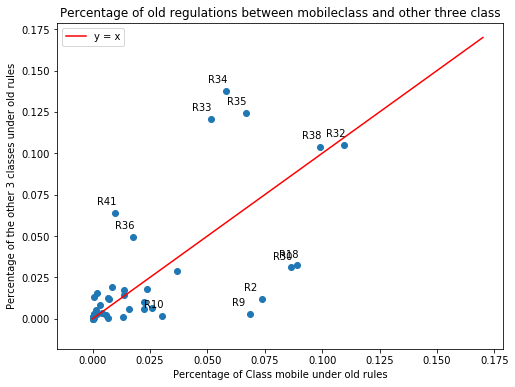

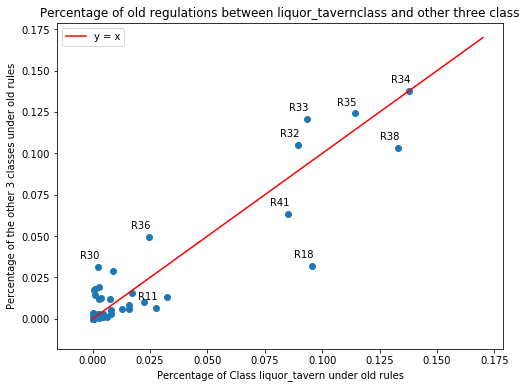

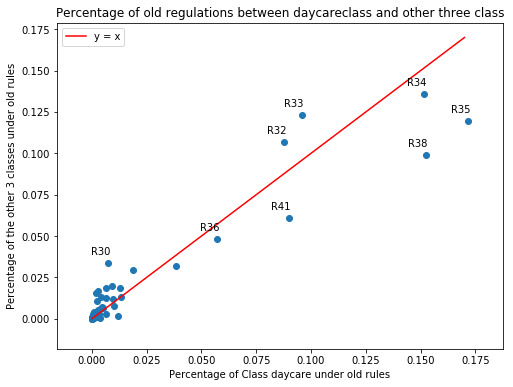

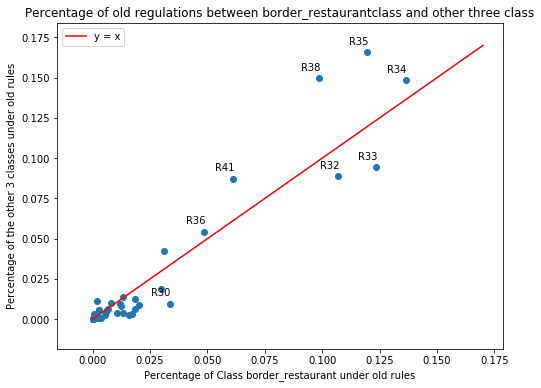

In [46]:
for i in range(4):
    x_index = [i]
    y_index = [0, 1, 2, 3]
    del y_index[i]    
    x_label = 'Percentage of Class '+ class_list[i] + ' under old rules'
    y_label = 'Percentage of the other 3 classes under old rules'
    title = 'Percentage of old regulations between ' + class_list[i] + 'class and other three class'
    text_size = [0.05, 0.05, 0.008, -0.005, 0.17, 0.02, 0.02]
    add_line = True
    plot_scatter(stats_cluster_old, x_index, y_index, x_label, y_label, title,  text_size, add_line)

**Analysis for Old Regulation (Before July 1 2018)**

Here we plot a scatter figure with each point represent specific type of old regulations (before July 1 2018), the x value of the point represents the occurance percentage of this regulation in one classes, and the y value of the point represents the occurance percentage of this regulation in other three class. 

Here we check the regulation contents (For brevity, not output specific content)
Occurs more often in **mobile** class: [R2, R9, R18, R30]

Occurs less often in **mobile** class: [R33, R34, R35]

Occurs more often in **liquor_tavern** class: [R18]

Occurs less often in **liquor_tavern** class: [R33]

Occurs more often in **daycare** class: [R35, R38]

Occurs less often in **daycare** class: [R32, R33]

Occurs more often in **border_restaurant** class: [R32, R33]

Occurs less often in **border_restaurant** class: [R35, R38]

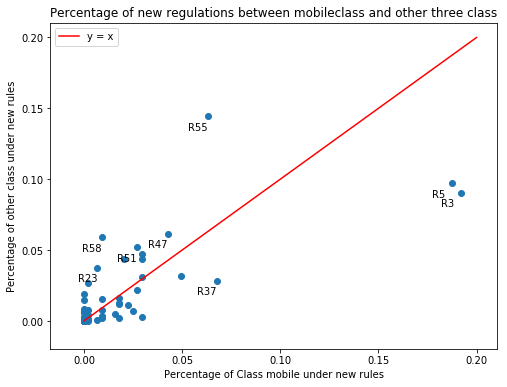

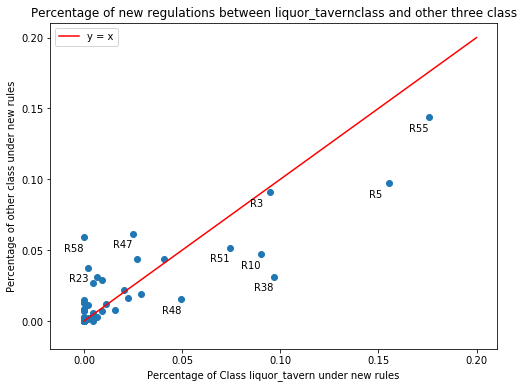

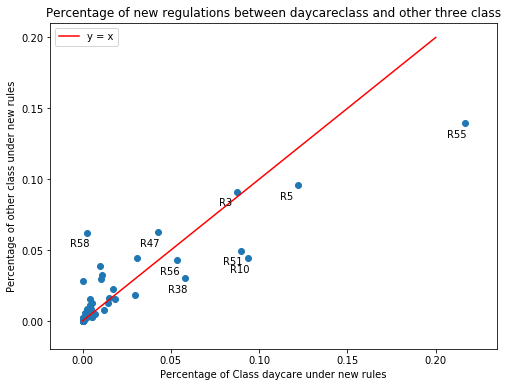

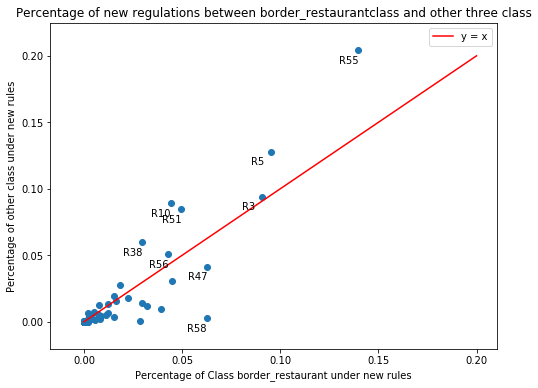

In [47]:
for i in range(4):
    x_index = [i]
    y_index = [0, 1, 2, 3]
    del y_index[i]    
    x_label = 'Percentage of Class '+ class_list[i] + ' under new rules'
    y_label ='Percentage of other class under new rules'
    title = 'Percentage of new regulations between ' + class_list[i] + 'class and other three class'
    text_size = [0.05, 0.05, 0.01, 0.01, 0.2, 0.03, 0.03]
    add_line = True
    plot_scatter(stats_cluster_new, x_index, y_index, x_label, y_label, title, text_size, add_line)

**Analysis for New Regulation (After July 1 2018)**

Here we plot a scatter figure with each point represent specific type of new regulation (after July 1 2018), the x value of the point represents the occurance percentage of this regulation in one classes, and the y value of the point represents the occurance percentage of this regulation in other three class. 

Here we check the regulation contents (For brevity, not output specific content) 
Occurs more often in **mobile** class: [R3, R5]

Occurs less often in **mobile** class: [R55]

Occurs more often in **liquor_tavern** class: [R38, R5]

Occurs less often in **liquor_tavern** class: [R58]

Occurs more often in **daycare** class: [R55]

Occurs less often in **daycare** class: [R58]

Occurs more often in **border_restaurant** class: [R58]

Occurs less often in **border_restaurant** class: [R55]

**Observation under the old and new regulation**  

1：The more common problem and less common problem of Class border_restaurant and Class daycare are almost the opposite. This is because these two categories take up most of the data, causing the total data to be subtracted from one of them is almost the other.

2：For class mobile，food temperature, clean water, employee health policy and harmful pests problem are relatively common, while facilities problem are relatively rare.

It's easy to understand that the cleanliness and water supply of mobile restaurants are really important, and they don't need complicated equipment itself, so the equipment problems are rare.

3：For liquor_tavern，ventilation, pests problem are relatively common, while clean and allergies problem are relatively rare

It's easy to understand that the ventilation pests problem of liquor and tavern are really important. And they have nothing to do with allergies, so related issues are rare.

4：For daycare, ventilation, garbage problem is relatively common, and the relationship between food and non-food problem and allergies problem are relatively rare.

For daycare establishments. Because there are many children, the problem of garbage cleaning is common. Since it is a daycrae place, it pays more attention to allergies, so allergy problems are rare.

5：For border_restaurant, the relationship between food and non-food problem and allergies problem are relatively common, ventilation and garbage problem is relatively rare

For general restaurant establishments. They pay more attention to the problem of cleaning, but because of the complexity of personnel and mobility, the relationship between food and non-food problem problems are more difficult to handle.

The above conclusions are basically in line with our perception.

## 4. Calculate the recurrence rate and occurrance percentage of each regulation 
Calculate the recurrence rate of each regulation and study its relationship with the occurrence percentage. Then we select some important regulations that both recurrance rate and occurrence percentage are high.

### The definition of the Recurrence Rate and Occurance Rate：
**Recurrance Rate**  
For a spcific regualtion A, the definition of the recurrance rate is the number of times without successful correction of this regulation A divided by the total number of occurrences of this regulation A.  
For each violation of this regulation, if it does not violated in the next check of **the same 'License #'**(we use license to distinguish a unique establishment), then it is a **successful correction**. Otherwise, it is a **failure correction**.   

_Note: the last violation of the specific regulation for each **License #** is not a valid number because it cannot be judged whether or not it had been successfully corrected_

**Occurrance Percentage**  
For a spcific regualtion A, the definition of the occurrance percentage is the number of violations of this specific regulation divided by the number of violations of all the regulations

In [48]:
def Recurrent_rate(chicago_):
    # This function calculate the Return rate.
    # This function simplifies the calculation process by using the sparse matrix method.
    max_size = 100
    
    occurrence_times = np.zeros(max_size)
    failure_to_correct_times = np.zeros(max_size)
    occurrence_times_each = np.zeros(max_size)
    failure_to_correct_times_each = np.zeros(max_size)

    # Pick out the data we need
    chicago_loced = chicago_.loc[:, "violation_number"]
    chicago_grouped = chicago_loced.groupby(chicago_['License #'])

    for name, group in chicago_grouped:
        sparse_a = None
        
        # Does not consider the data of License # = 0 and License # = 999 (default data)
        if name == -999:
            continue
        if name == 0:
            continue
            
        # Statistics for each license #
        for i in list(group):
            col = np.array(list(i))
            size = col.size
            row = np.zeros(size)
            data = np.ones(size)
            
            #  convert to sparse matrices
            sparse_a_each = csr_matrix((data, (row, col)), shape=(1, max_size)).toarray()
            if sparse_a is None:
                sparse_a = sparse_a_each
            else:
                sparse_a = np.vstack((sparse_a_each, sparse_a))
                
        if sparse_a.shape[0] > 1:
            #  delete the last line, or delete the first line and get two new arrays
            a_min_l = np.delete(sparse_a, sparse_a.shape[0]-1, axis = 0)
            a_min_f = np.delete(sparse_a, 0, axis = 0)
            
            # Summing the array 'a_min_l' (axis = 0), we can get the number of occurrences of each Regulation Series Number.
            occurrence_times_each = np.sum(a_min_l,axis=0)
            
            # Perform an "AND" operation on a_min_f and a_min_l.
            a_and = np.logical_and(a_min_l, a_min_f)

            # Summing the array 'a_and' (axis = 0), we can get the number of "failure to correct" of each Regulation Series Number.
            failure_to_correct_times_each = np.sum(a_and,axis=0)
        
        # Add the statistics of each "License #"
        occurrence_times = occurrence_times + occurrence_times_each
        failure_to_correct_times = failure_to_correct_times + failure_to_correct_times_each
        occurrence_times_each = np.zeros(max_size)
        failure_to_correct_times_each = np.zeros(max_size)
    
    # Calculate the ratio of the SUM_failure_to_correct_times and SUM_occurrence_times to get the recurrent rate of each Regulation Series Number.
    return failure_to_correct_times/occurrence_times

**Recurrent_rate is a function used to calculate the Recurrent rate. We use an example to explain the algorithm.**

For convenience, we assume there are a total of 5 Regulation Series Number. For a 'License #'. There are a total of 5 inspections. The results of ten inspections are as follows.

In [49]:
a = [[2, 3], [1, 2, 3], [1, 2, 3], [2, 4, 5], [2, 5]]

We first convert them into sparse matrices

In [50]:
sparse_a = [[0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 0, 1, 0, 1, 1], [0, 0, 1, 0, 0, 1]]

First we delete the last line, or delete the first line and get two new arrays.

In [51]:
a_min_l = [[0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 0, 1, 0, 1, 1]]
a_min_f = [[0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0], [0, 0, 1, 0, 1, 1], [0, 0, 1, 0, 0, 1]]

Summing the array 'a_min_l' (axis = 0),  we can get the number of occurrences of each Regulation Series Number.

In [52]:
occurrence_times = [[0, 2, 4, 3, 1, 1]]

Perform an "AND" operation on a_min_f and a_min_l. ("AND" operation is true if and only if Regulation Series Number occurrence and failure to correct.)

In [53]:
a_and = [[0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 1, 0, 0, 1]]

Summing the array 'a_and' (axis = 0),  we can get the number of "failure to correct" of each Regulation Series Number.

In [54]:
failure_to_correct_times = [[0, 1, 4, 2, 0, 1]]

We add the statistics of each "License #", and then calculate the ratio of the SUM_failure_to_correct_times and SUM_occurrence_times to get the recurrent rate of each Regulation Series Number.

In [55]:
recurrent_rate_of_this_License_ = [0, 0.5, 1, 0.667, 0, 1]

**Example end**

Then we calculate the RR of each regulation and draw a bar graph

/Users/wt.huang/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


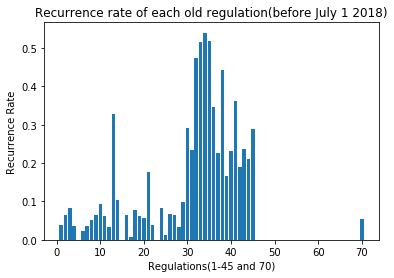

new


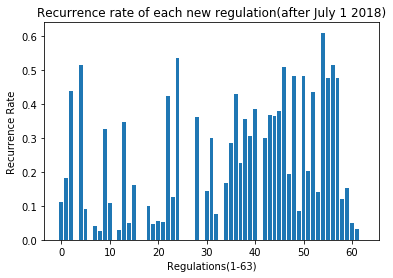

In [56]:
# Separation data
before = chicago[chicago['Inspection Date'] < datetime(2018, 7, 1)].copy()
after = chicago[chicago['Inspection Date'] >= datetime(2018, 7, 1)].copy()

# Calculate the recurrent rate under old regulation
before_data = Recurrent_rate(before)

# Choose the violation number we need
before_data[46] = before_data[70]
before_data = before_data[1:47]

# Draw a bar chart of the recurrent rate of each Regulation Series Number under old regulation
x = np.arange(1, 47)
x[45] = 70
plt.bar(x, before_data)
plt.xlabel('Regulations(1-45 and 70)')
plt.ylabel('Recurrence Rate')
plt.title('Recurrence rate of each old regulation(before July 1 2018)')
plt.show()

# Calculate the recurrent rate under new regulation 
after_data = Recurrent_rate(after)

# Choose the violation number we need
after_data = after_data[1:64]
# Draw a bar chart of the recurrent rate of each Regulation Series Number under new regulation
print("new")
plt.bar(range(len(after_data)), after_data)
plt.xlabel('Regulations(1-63)')
plt.ylabel('Recurrence Rate')
plt.title('Recurrence rate of each new regulation(after July 1 2018)')
plt.show()

For each regulation, let its **Occurrence Percentage** as x-data and **Reccurance Rate** as y-data to draw the scatter plot. 

And Looking for some important Regulation (Both recurrent rate and occurrence percentage are high).

**Analysis of the old Regulation (before July 1 2019)**

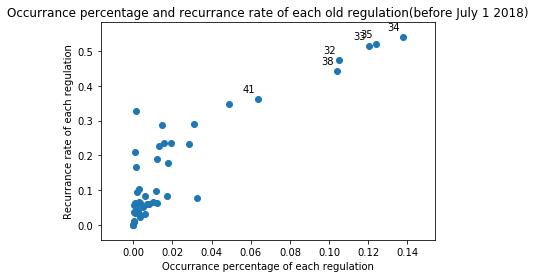

In [57]:
# Calculation occurrence percentage for each Regulation Series Number
before_percentage = chicago_before.groupby('Regulation Series Number').count()
index_list = before_percentage._stat_axis.values.tolist()
index_list = [int(i[1:])for i in index_list]
index = list(map(int, index_list))
before_percentage.index = index
before_percentage = before_percentage.sort_index()
before_percentage = before_percentage.iloc[:, 0]
sum_before_percentage = np.sum(before_percentage)
before_percentage = before_percentage/sum_before_percentage

# Make the tag
text = before_percentage._stat_axis.values.tolist()

# Draw the scatter plot
plt.scatter(before_percentage, before_data)
plt.xlabel('Occurrance percentage of each regulation')
plt.ylabel('Recurrance rate of each regulation')
plt.title('Occurrance percentage and recurrance rate of each old regulation(before July 1 2018)')
for j in range(len(before_data)):
    if(before_data[j] >= 0.3):
        if(before_percentage[j+1] >= 0.05):
            plt.annotate(text[j], xy = (before_percentage[j+1], before_data[j]), xytext = (before_percentage[j+1] - 0.008, before_data[j] + 0.02))
plt.show()

We can see that recurrent rate and occurrence percentage of Regulation Series Number ['R32', 'R33', 'R34', 'R35', 'R38', 'R41'] before the regulation change are very high. We need to focus on these Regulation Series Number later.

In [58]:
Old_Important_Regulation_Series_Number = ['R32', 'R33', 'R34', 'R35', 'R38', 'R41']

**Analysis of the new Regulation (after July 1 2019)**

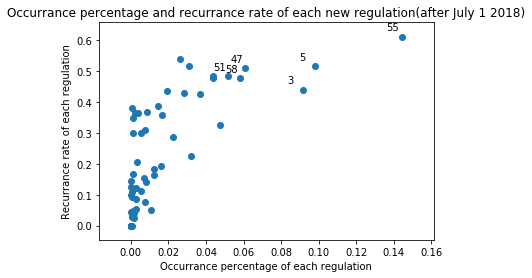

In [59]:
# Calculation occurrence percentage for each Regulation Series Number
after_percentage = chicago_after.groupby('Regulation Series Number').count()
index_list = after_percentage._stat_axis.values.tolist()
index_list = [int(i[1:])for i in index_list]
index = list(map(int, index_list))
after_percentage.index = index
after_percentage = after_percentage.sort_index()
after_percentage = after_percentage.iloc[:, 0]
sum_after_percentage = np.sum(after_percentage)
after_percentage = after_percentage/sum_after_percentage

# Make the tag
text = after_percentage._stat_axis.values.tolist()

# Draw the scatter plot
plt.scatter(after_percentage, after_data)
plt.xlabel('Occurrance percentage of each regulation')
plt.ylabel('Recurrance rate of each regulation')
plt.title('Occurrance percentage and recurrance rate of each new regulation(after July 1 2018)')
for j in range(len(after_data)):
    if(after_data[j] >= 0.3):
        if(after_percentage[j+1] >= 0.05):
            plt.annotate(text[j], xy = (after_percentage[j+1], after_data[j]), xytext = (after_percentage[j+1] - 0.008, after_data[j] + 0.02))
plt.show()

We can see that recurrent rate and occurrence percentage of Regulation Series Number ['R3', 'R5', 'R47', 'R51', 'R55', 'R58'] after the regulation change are very high. We need to focus on these Regulation Series Number later.

In [60]:
New_Important_Regulation_Series_Number = ['R3', 'R5', 'R47', 'R51', 'R55', 'R58']

In addition, we can also see that the  recurrent rate and occurrence percentage of Regulation Series Number have a significant positive correlation. 

And the rate of return has obviously increased after the revision of the regulations. It may be that the review after the revision becomes more strict

## 5. For some important violation number generate a word cloud according to comments

In [61]:
#Import the NLP library nltk and download some resources
import nltk
from nltk import ngrams
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wt.huang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wt.huang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wt.huang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [68]:
def word_cloud(data, Regulation_Series_Number, new_or_old, print_pic):
    """count word frequency and draw word cloud
    Args:
        data: Text to be counted or draw.
        Regulation_Series_Number: Regulation Series Number.
        new_or_old: the Regulation_Series_Number is under new or old regulation.
        print_pic (Boolean): whether print picture in jupyter notebook. If False only output .png file in fold.
    """
    if(print_pic == True):
        print(Regulation_Series_Number + "`s word cloud drawing:")
    else:
        print(Regulation_Series_Number + "`s word frequency statistics:")
    data = data.values
    data = ''.join(data)
    words = word_tokenize(data)
    
    # Delete stop words
    words = dict(Counter(words))
    d = {}
    for i in words:
        if (i not in stopwords.words('english')):
            if (i not in stoplist):
                d[i] = words[i]
                
    # Analysis word frequency
    if(print_pic == False):
        d_rank = sorted(d, key = d.get, reverse = True)
        for e in d_rank:
            if(new_or_old == "new"):
                if(d[e] > 1000):
                    print(e, d[e])
            if(new_or_old == "old"):
                if(d[e] > 4000):
                    print(e, d[e])
                

    # Drawing word cloud
    mask_image = np.array(Image.open("./data/chicago.jpg"))
    mask_image[mask_image > 250] = 255

    word_cloud = WordCloud(colormap = "Dark2", background_color='white', mask = mask_image, 
                        width = 1165, height = 607,  max_words=1000, min_font_size = 1, relative_scaling = 0.2).generate_from_frequencies(d)
    if(print_pic == True):
        plt.figure(figsize = (14,20))
        plt.imshow(word_cloud, interpolation="bilinear", cmap = plt.cm.autumn)
        plt.axis('off')
        plt.figure(figsize = (10,6))
        plt.show()
    word_cloud.to_file("./data/word_cloud_" + Regulation_Series_Number + "_" + new_or_old +".png")
    print()

For brevity, we only discuss New "R3" here. If you need other data, you can remove the comments and re-run

R3`s word frequency statistics:
employee 14127
health 13690
policy 11724
priority 9654
foundation 8957
provide 7511
citation 7291
instructed 6589
site 5308
violation 4801
maintain 2791
must 2580
7-38-010. 2434
premises 2172
employees 2083
7-38-012 1776
issued 1714
7-38-010 1599
signed 1499
observed 1484
policy/training 1468
issued.observed 1394
# 1308
n 1297
manager 1271
written 1189
issued.no 1083

R3`s word cloud drawing:


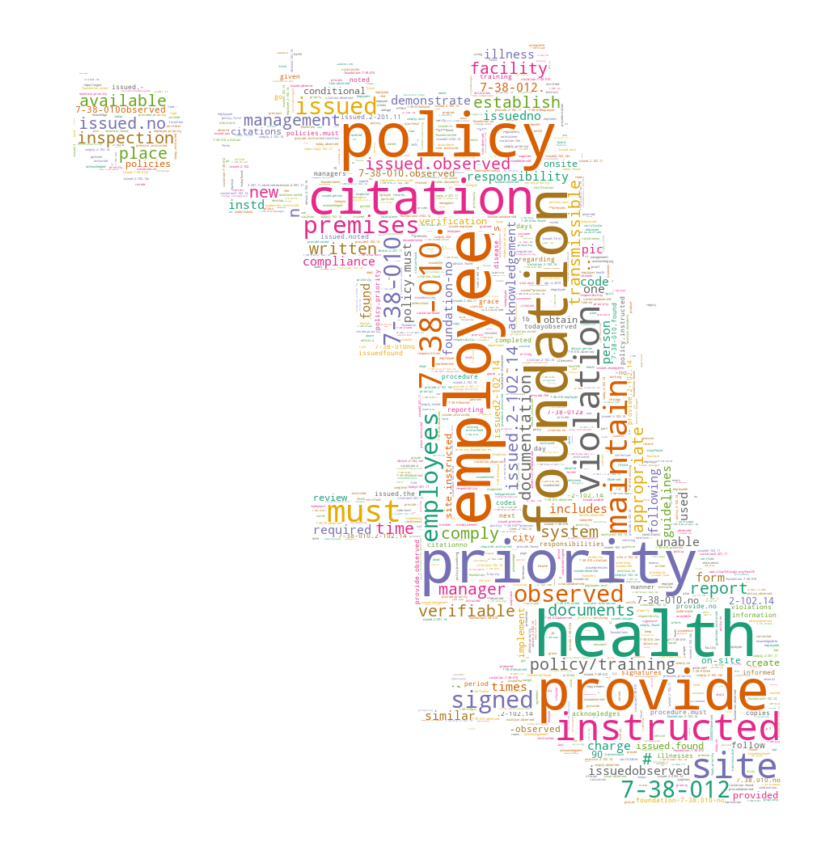

<Figure size 720x432 with 0 Axes>

In [69]:
# Drawing word cloud / statistics word frequency for each important Violations Number

import matplotlib.pyplot as plt
from wordcloud.wordcloud import WordCloud
from PIL import Image
import collections 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

lemmatizer = WordNetLemmatizer()

stoplist = ['.', ',', '(', ')', 'food']

    
# for Regulation_Series_Number in Old_Important_Regulation_Series_Number:
#     data = chicago_before.loc[chicago_before["Regulation Series Number"] == Regulation_Series_Number, "Comment"]
#     word_cloud(data, Regulation_Series_Number, "old", print_pic = False)
    
# for Regulation_Series_Number in New_Important_Regulation_Series_Number:
#     data = chicago_after.loc[chicago_after["Regulation Series Number"] == Regulation_Series_Number, "Comment"]
#     word_cloud(data, Regulation_Series_Number, "new", print_pic = False)

Regulation_Series_Number = "R3"
data = chicago_after.loc[chicago_after["Regulation Series Number"] == Regulation_Series_Number, "Comment"]
word_cloud(data, Regulation_Series_Number, "new", print_pic = False)
word_cloud(data, Regulation_Series_Number, "new", print_pic = True)

Compare with the Regulation Content:
3. management, food employee and conditional employee; knowledge, responsibilities and reporting

We can see that this regulation is indeed discussing employee-related content. And it can be seen that 7-38-010 is a very relevant regulation.

## Yelp data

In [70]:
combined = pd.read_csv('yelp.csv')
yelp = combined.drop(columns=['Unnamed: 0', 'rank'])
yelp.head()

,business_name,review_count,categories,rating,address,price_range,url
0,kuma's corner - belmont,5000,"Pubs,Burgers",4.0,2900 w belmont ave avondale,$$,https://www.yelp.com/biz/kumas-corner-belmont-...
1,hopleaf,2077,Gastro Pubs,4.0,5148 n clark st andersonville,$$,https://www.yelp.com/biz/hopleaf-chicago?osq=R...
2,honey butter fried chicken,1874,"Chicken Shop,Takeaway & Fast Food,Breakfast & ...",4.0,3361 n elston ave avondale,$$,https://www.yelp.com/biz/honey-butter-fried-ch...
3,m.henry,1692,"Breakfast & Brunch,American (New),Cafes",4.0,5707 n clark st andersonville,$$,https://www.yelp.com/biz/m-henry-chicago?osq=R...
4,big jones,1479,"Southern,Breakfast & Brunch,Bars",4.0,5347 n clark st andersonville,$$,https://www.yelp.com/biz/big-jones-chicago?osq...


In [71]:
yelp.shape

(7675, 7)

In [ ]:
## Join Chicago and Yelp by address, name (contains)

In [72]:
# join by address
# Join by he first four digits in an address only
chicago['A_code'] = chicago['Address'].apply(lambda x: x.split(" ")[0])
yelp['a_code'] = yelp['address'].apply(lambda x: x.split(" ")[0])
join_by_address = chicago.merge(yelp, left_on = 'A_code', right_on = 'a_code')
join_by_address.head()
print(join_by_address.shape)

(793787, 24)


In [73]:
# filter by name: aka name contains business name, or business name contains aka name
sim_join_name = join_by_address[join_by_address.apply(lambda x: x['AKA Name'] in x['business_name'] or \
                                                 x['business_name'] in x['AKA Name'], axis = 1)]

def simlarity_join(row):
    A = row['Address'].split(' ')[1]
    a = row['address'].split(' ')[1]
    if len(A) == 1 and len(a) == 1:
        return a == A
    else:
        return True
    
sim_join = sim_join_name[sim_join_name.apply(lambda x: simlarity_join(x), axis = 1)]
sim_join.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,violation_number,A_code,business_name,review_count,categories,rating,address,price_range,url,a_code
0,2345318,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2019-11-08,canvass re-inspection,...,"{5, 58, 3}",2620,subway restaurants,8,"Sandwiches,Fast Food",3.5,2620 n narragansett ave montclare,$,https://www.yelp.com/biz/subway-restaurants-ch...,2620
2,2321166,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2019-11-06,canvass,...,"{57, 10, 5, 22, 58, 33, 3}",2620,subway restaurants,8,"Sandwiches,Fast Food",3.5,2620 n narragansett ave montclare,$,https://www.yelp.com/biz/subway-restaurants-ch...,2620
5,2290717,papa john's pizza,papa john's pizza,1545897,restaurant,Risk 2 (Medium),2620 n narragansett ave,60639.0,2019-05-30,canvass,...,"{5, 3}",2620,papa john's pizza,17,Pizza,3.5,2620 n narragansett ave montclare,$,https://www.yelp.com/biz/papa-johns-pizza-chic...,2620
12,2144892,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2018-02-13,canvass re-inspection,...,{},2620,subway restaurants,8,"Sandwiches,Fast Food",3.5,2620 n narragansett ave montclare,$,https://www.yelp.com/biz/subway-restaurants-ch...,2620
14,2144588,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2018-02-06,canvass,...,"{42, 34, 16}",2620,subway restaurants,8,"Sandwiches,Fast Food",3.5,2620 n narragansett ave montclare,$,https://www.yelp.com/biz/subway-restaurants-ch...,2620


In [74]:
print('shape: ', sim_join.shape)
print("According license: ", sim_join['License #'].nunique())
print("According to resturant address: ", sim_join.address.nunique())
print("According to business name: ", sim_join["business_name"].nunique())

shape:  (45870, 24)
According license:  5169
According to resturant address:  3286
According to business name:  2757


In [75]:
# compare 3583 and 3276 means have the different resturants in the same address
# compare license 5137 and 3583(business_name, address] means have the same resturant but different license? why?
print(sim_join[['business_name', 'address']].drop_duplicates())

                        business_name                            address
0                  subway restaurants  2620 n narragansett ave montclare
5                   papa john's pizza  2620 n narragansett ave montclare
132     kerelys cuban cafe & pizzeria      2934 n milwaukee ave avondale
220                    peace of pizza             1801 w 95th st beverly
464                         big shark         2553 e 75th st south shore
...                               ...                                ...
793744                      pauline's  1754 w balmoral ave andersonville
793752             uncle's restaurant     6263 n mccormick rd north park
793753            garcia's restaurant      4760 n lincoln ave ravenswood
793756                      lula cafe    2537 n kedzie blvd logan square
793762              the lunch machine           1319 w wilson ave uptown

[3596 rows x 2 columns]


In [76]:
sim_join[['AKA Name', 'Address', 'business_name', 'address']].drop_duplicates().head(500)
# spot some mistakes during merge 43860

,AKA Name,Address,business_name,address
0,subway,2620 n narragansett ave,subway restaurants,2620 n narragansett ave montclare
5,papa john's pizza,2620 n narragansett ave,papa john's pizza,2620 n narragansett ave montclare
132,kerelys cuban cafe,2934 n milwaukee ave,kerelys cuban cafe & pizzeria,2934 n milwaukee ave avondale
220,"peace of pizza, llc",1801 w 95th st,peace of pizza,1801 w 95th st beverly
464,big sharks,2553 e 75th st,big shark,2553 e 75th st south shore
...,...,...,...,...
218397,naf naf grill,309 w washington st,naf naf grill,309 w washington st the loop
218406,bozii,309 w lake st,bozii,309 w lake st the loop
218535,simple delights,6255 n mccormick rd,simple delights,6255 n mccormick rd north park
218593,best sub,2653 w north ave,best submarine,2653 w north ave west town


# More structured and informed plan until the final milestone

## TO-DO 1: By the end of 02.12.2019

### Part C Yelp related analysis (combine the chicago dataset with yelp)

We have already merged the chicago dataset with the Yelp dataset we scrapped from Yelp.com. For the next step we want to analyse the following questions:
1. Is there a clear correlation between the health score of a restaurant with its **averaging rating**? If yes, to what extent does it affect the rating?
2. Is there a clear correlation between the health score of a restaurant with its **cuisine type**? If yes, to what extent does it affect the rating?
3. Is there a clear correlation between the health score of a restaurant with its **average price**? If yes, to what extent does it affect the rating?

## TO-DO 2: By the end of 09.12.2019
1. Find more interactive ways to visualize our plots on the blog post.
2. Organise all the observations and analysis to fit into a data story.

## TO-DO 3: By the end of 16.12.2019
1. Use Jekyll to present our data story.
2. Produce the poster for presentation.